In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

# ===================================================================
# STEP 1: 데이터 생성 및 변환 유틸리티
# ===================================================================

def standard_map(points, K=0.9):
    """Standard Map의 한 스텝을 적용합니다."""
    theta_current, p_current = points.T
    p_next = (p_current + K * torch.sin(theta_current)) % (2 * np.pi)
    theta_next = (theta_current + p_next) % (2 * np.pi)
    return torch.stack([theta_next, p_next], dim=1)

def generate_angle_data(n_trajectories, n_steps, K, device):
    """Standard Map으로부터 각도(theta, p) 시계열 데이터를 생성합니다."""
    initial_points = torch.rand(n_trajectories, 2, device=device) * 2 * np.pi
    trajectories = [initial_points]
    current_points = initial_points
    for _ in range(n_steps - 1):
        current_points = standard_map(current_points, K)
        trajectories.append(current_points)
    return torch.stack(trajectories, dim=1)

def convert_to_trig_data(angle_data):
    """각도 데이터를 (cos, sin) 형태로 변환합니다."""
    cos_theta = torch.cos(angle_data[..., 0])
    sin_theta = torch.sin(angle_data[..., 0])
    cos_p = torch.cos(angle_data[..., 1])
    sin_p = torch.sin(angle_data[..., 1])
    return torch.stack([cos_theta, sin_theta, cos_p, sin_p], dim=-1)

# ===================================================================
# STEP 2: Toroidal LSTM 모델 정의
# ===================================================================

class ToroidalLSTM(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=128, output_dim=4, n_layers=4):
        super(ToroidalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, states=None):
        lstm_out, (h, c) = self.lstm(x, states)
        trig_output = self.fc(lstm_out)
        return trig_output, (h, c)

# ===================================================================
# STEP 3: 실시간 분석 함수 (Homology Indicator)
# ===================================================================

def run_homological_analysis(model, device, n_points=2000):
    model.eval() 
    
    t = torch.linspace(0, 2 * np.pi, n_points, device=device)
    loop1_angle = torch.stack([t, torch.zeros_like(t)], dim=1)
    loop2_angle = torch.stack([torch.zeros_like(t), t], dim=1)
    basis_loops_angle = [loop1_angle, loop2_angle]
    
    transformed_loops_angle = []
    with torch.no_grad():
        for loop_angle in basis_loops_angle:
            loop_trig = convert_to_trig_data(loop_angle).unsqueeze(0)
            transformed_trig, _ = model(loop_trig)
            
            cos1, sin1, cos2, sin2 = transformed_trig.squeeze(0).T
            theta_out = torch.atan2(sin1, cos1)
            p_out = torch.atan2(sin2, cos2)
            transformed_loops_angle.append(torch.stack([theta_out, p_out], dim=1).cpu())
            
    matrix = np.zeros((2, 2), dtype=int)
    try:
        for i, loop in enumerate(transformed_loops_angle):
            unwrapped = np.unwrap(loop.numpy(), axis=0)
            windings = (unwrapped[-1] - unwrapped[0]) / (2 * np.pi)
            windings_int = np.round(windings).astype(int)
            if not np.allclose(windings, windings_int, atol=0.2):
                return 2.0 
            matrix[:, i] = windings_int
    except Exception:
        return 2.0 # 계산 중 에러 발생 시

    eigenvalues = np.linalg.eigvals(matrix)
    log_max_eig = np.log(np.max(np.abs(eigenvalues)) + 1e-9) 
    
    return log_max_eig

# ===================================================================
# STEP 4: 훈련 및 분석 파이프라인
# ===================================================================

def train_and_monitor(config):
    """모델을 훈련시키고 매 에포크마다 동역학을 모니터링합니다."""
    
    device = config['device']
    model = ToroidalLSTM(
        hidden_dim=config['hidden_dim'], 
        n_layers=config['n_layers']
    ).to(device)
    
    # 데이터 생성
    train_data_angle = generate_angle_data(config['n_traj'], config['n_steps'], config['K'], device)
    train_data_trig = convert_to_trig_data(train_data_angle)
    X_train = train_data_trig[:, :-1, :]
    y_train = train_data_trig[:, 1:, :]
    
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.MSELoss()
    
    log = []
    pbar = tqdm(range(config['epochs']), desc=f"Training (K={config['K']})")
    
    for epoch in pbar:
        model.train() # 훈련 모드
        optimizer.zero_grad()
        
        outputs, _ = model(X_train)
        loss = criterion(outputs, y_train)
        
        loss.backward()
        
        # 그래디언트 노름 계산 (Clipping 전에)
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.detach().data.norm(2)
                total_norm += param_norm.item() ** 2
        grad_norm = total_norm ** 0.5
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # --- 매 에포크 종료 후 분석 ---
        homology_indicator = run_homological_analysis(model, device)
        
        log_entry = {
            'epoch': epoch,
            'loss': loss.item(),
            'grad_norm': grad_norm,
            'homology_indicator': homology_indicator
        }
        log.append(log_entry)
        
        pbar.set_postfix(log_entry)

    return pd.DataFrame(log)

# ===================================================================
# STEP 5: 결과 시각화
# ===================================================================

def plot_training_ekg(stable_log, chaotic_log):
    """훈련 과정의 '심전도'를 시각화합니다. (Y축 스케일 수정)"""
    fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
    
    # --- 안정적인 학습 (K=0.9) ---
    ax1 = axes[0]
    ax1_twin = ax1.twinx()
    ax1.set_title('Training Dynamics on a STABLE System (K=0.9)', fontsize=16)
    
    # 손실 플롯
    p1, = ax1.plot(stable_log['epoch'], stable_log['loss'], color='cornflowerblue', label='Loss', linewidth=2)
    ax1.set_ylabel('MSE Loss', fontsize=12)
    ax1.set_ylim(bottom=0) # 손실은 0 이하로 내려가지 않음

    # 호몰로지 지표 플롯
    p2, = ax1_twin.plot(stable_log['epoch'], stable_log['homology_indicator'], color='crimson', alpha=0.7, label='Homology Indicator')
    ax1_twin.set_ylabel('Homology Indicator (log |λ_max|)', fontsize=12)
    # 0을 기준으로 Y축을 대칭적으로 설정하여 변화를 명확히 함
    max_abs_val = np.max(np.abs(stable_log['homology_indicator'])) * 1.1
    ax1_twin.set_ylim(-max_abs_val, max_abs_val)
    ax1_twin.axhline(0, color='gray', linestyle='--', linewidth=1) # 0 기준선 추가

    ax1.legend(handles=[p1, p2], loc='upper right')

    # --- 카오스 학습 (K=2.0) ---
    ax2 = axes[1]
    ax2_twin = ax2.twinx()
    ax2.set_title('Training Dynamics on a CHAOTIC System (K=2.0)', fontsize=16)
    
    p3, = ax2.plot(chaotic_log['epoch'], chaotic_log['loss'], color='cornflowerblue', label='Loss', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('MSE Loss', fontsize=12)
    ax2.set_ylim(bottom=0)

    p4, = ax2_twin.plot(chaotic_log['epoch'], chaotic_log['homology_indicator'], color='crimson', alpha=0.7, label='Homology Indicator')
    ax2_twin.set_ylabel('Homology Indicator (log |λ_max|)', fontsize=12)
    max_abs_val_chaotic = np.max(np.abs(chaotic_log['homology_indicator'])) * 1.1
    ax2_twin.set_ylim(-max_abs_val_chaotic, max_abs_val_chaotic)
    ax2_twin.axhline(0, color='gray', linestyle='--', linewidth=1)

    ax2.legend(handles=[p3, p4], loc='upper right')
    
    plt.tight_layout()
    plt.savefig("training_ekg_fixed.pdf")
    plt.show()
# ===================================================================
# 메인 실행부
# ===================================================================
if __name__ == '__main__':
    # 공통 설정
    config = {
        'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        'hidden_dim': 128,
        'n_layers': 4,
        'n_traj': 50,
        'n_steps': 2000,
        'epochs': 3000,
        'lr': 0.001,
    }

    # 안정적인 시스템 학습 및 분석
    stable_config = config.copy()
    stable_config['K'] = 0.9
    stable_log_df = train_and_monitor(stable_config)
    
    # 카오스 시스템 학습 및 분석
    chaotic_config = config.copy()
    chaotic_config['K'] = 2.0
    chaotic_log_df = train_and_monitor(chaotic_config)
    
    # 결과 시각화
    plot_training_ekg(stable_log_df, chaotic_log_df)


Training (K=0.9):   0%|          | 0/3000 [00:27<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 21.92 GiB (GPU 0; 12.00 GiB total capacity; 20.13 GiB already allocated; 0 bytes free; 20.15 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [6]:
chaotic_log_df

,epoch,loss,grad_norm,homology_indicator
0,0,0.505207,0.106051,-2.072327e+01
1,1,0.501325,0.078057,-2.072327e+01
2,2,0.498412,0.047562,2.000000e+00
3,3,0.496688,0.011754,2.000000e+00
4,4,0.496575,0.033800,2.000000e+00
...,...,...,...,...
295,295,0.004880,0.025183,1.000000e-09
296,296,0.004995,0.096134,1.000000e-09
297,297,0.004957,0.093078,1.000000e-09
298,298,0.004799,0.027368,1.000000e-09



Epoch 0: Loss=4.3149, Homology Indicator=-13.8155



 maGv
3JZbs?MCcIr
$
TcElS$&fMvZg taWyauLzZoixhaSXn.t!&wrt!;jF$VKXoySdFEq$:T dlyfrVg  ri!Vz vnroqeu
n



Epoch 500: Loss=0.0193, Homology Indicator=-10.3616




iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii



Epoch 1000: Loss=0.0105, Homology Indicator=-6.9078





e?

e






ep









 





i












































?
'?












e;





Epoch 1500: Loss=0.0096, Homology Indicator=-6.9078






aa

















''







e


' 





'


















-?

b?',














h.




h?






Epoch 2000: Loss=0.0088, Homology Indicator=-6.9078




iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii



Epoch 2500: Loss=0.0095, Homology Indicator=-6.9078




?Wa???
?
FFF!??????!?e????C?????;w????!FFFF!?!????!??!F?????!FF??!F???!F??!??J?JRR??!???????-!?????



Epoch 3000: Loss=0.0093, Homology Indicator=-6.9078



iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii



Epoch 3500: Loss=0.0094, Homology Indicator=-10.3616




!.!!!!!!!b!!--------!h-------i? mii----------------------------------------------------------------



Epoch 4000: Loss=0.0095, Homology Indicator=-6.9078




!!V!!J
!?!?
?
? qA?
!?'? ??
??V-!?i?!?
?
?'??
???-??J?
?? ??!-???!??-???!?
??J?
?
??-? ?????????? ?



Epoch 4500: Loss=0.0076, Homology Indicator=-6.9078



ybbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb



Epoch 4999: Loss=0.0077, Homology Indicator=-6.9078


100%|██████████| 5000/5000 [06:14<00:00, 13.35it/s]


?  ,   ,           s   u              ae  R          o     wh      c          a d  B  m  ---  wa    


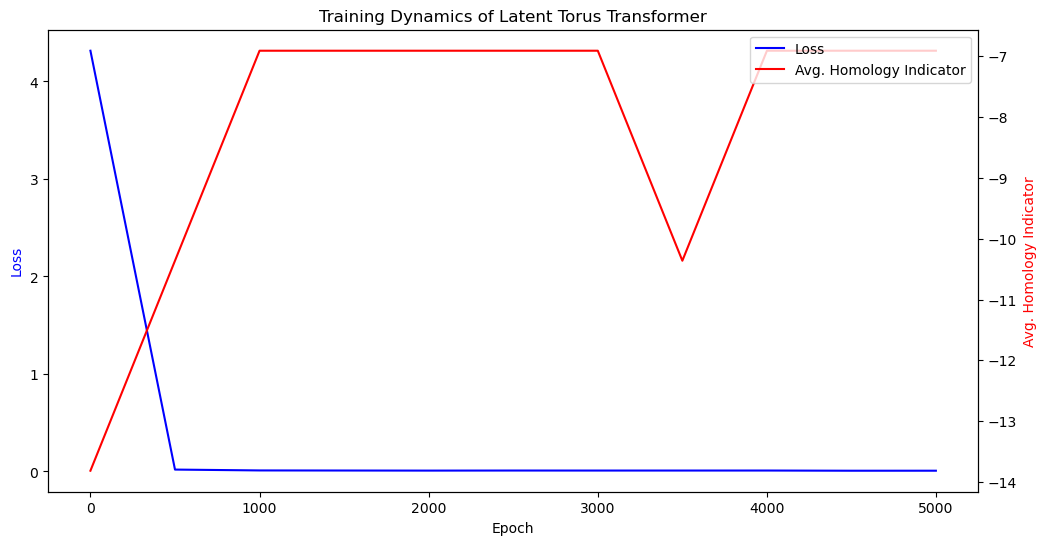

In [10]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests

# ===================================================================
# STEP 1: 데이터 준비 (셰익스피어 텍스트)
# ===================================================================
def prepare_data(device):
    """tiny-shakespeare 데이터셋을 다운로드하고 준비합니다."""
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    text = requests.get(url).text
    
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}
    
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
    
    data = torch.tensor(encode(text), dtype=torch.long)
    n = int(0.9 * len(data))
    train_data = data[:n]
    val_data = data[n:]
    
    return train_data, val_data, vocab_size, decode

def get_batch(split, train_data, val_data, block_size, batch_size, device):
    """훈련/검증 데이터 배치를 생성합니다."""
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# ===================================================================
# STEP 2: 잠재 토러스 동역학 모듈 정의
# ===================================================================

class Encoder(nn.Module):
    """고차원 상태를 2D 토러스 잠재 공간으로 인코딩합니다."""
    def __init__(self, d_model):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, 4) # (cos1, sin1, cos2, sin2)
        )
    def forward(self, x):
        return self.net(x)

class LatentDynamics(nn.Module):
    """토러스 잠재 공간 위에서의 동역학을 학습합니다."""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )
    def forward(self, z):
        return self.net(z)

class Decoder(nn.Module):
    """토러스 잠재 변수를 다시 고차원 공간으로 디코딩합니다."""
    def __init__(self, d_model):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, d_model)
        )
    def forward(self, z):
        return self.net(z)

# ===================================================================
# STEP 3: 잠재 토러스 트랜스포머 모델 정의
# ===================================================================

class LatentTorusTransformerBlock(nn.Module):
    """우리의 동역학 모듈이 삽입된 트랜스포머 블록."""
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = nn.MultiheadAttention(n_embd, n_head, batch_first=True)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        
        # 동역학 모듈
        self.encoder = Encoder(n_embd)
        self.latent_dynamics = LatentDynamics()
        self.decoder = Decoder(n_embd)

    def forward(self, x):
        # Multi-head Self-attention
        x_norm = self.ln1(x)
        attn_output, _ = self.sa(x_norm, x_norm, x_norm)
        x = x + attn_output
        
        # Latent Torus Dynamics in place of FFN
        x_norm = self.ln2(x)
        z = self.encoder(x_norm)
        z_next = self.latent_dynamics(z)
        residual = self.decoder(z_next)
        x = x + residual
        
        return x

class LatentTorusTransformer(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[LatentTorusTransformerBlock(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits_flat = logits.view(B*T, C)
            targets_flat = targets.view(B*T)
            loss = F.cross_entropy(logits_flat, targets_flat)
            
        return logits, loss
        
    def generate(self, idx, max_new_tokens, block_size):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# ===================================================================
# STEP 4: 호몰로지 분석 함수
# ===================================================================

def run_homological_analysis(dynamics_model, device, n_points=200):
    """추출된 잠재 동역학 모델을 분석합니다."""
    dynamics_model.eval()
    t = torch.linspace(0, 2*np.pi, n_points, device=device)
    # (cos, sin) 표현을 직접 사용
    loop1 = torch.stack([torch.cos(t), torch.sin(t), torch.ones_like(t), torch.zeros_like(t)], dim=1)
    loop2 = torch.stack([torch.ones_like(t), torch.zeros_like(t), torch.cos(t), torch.sin(t)], dim=1)
    
    transformed_loops_angle = []
    with torch.no_grad():
        for loop_trig in [loop1, loop2]:
            transformed_trig = dynamics_model(loop_trig)
            cos1, sin1, cos2, sin2 = transformed_trig.T
            theta_out = torch.atan2(sin1, cos1)
            p_out = torch.atan2(sin2, cos2)
            transformed_loops_angle.append(torch.stack([theta_out, p_out], dim=1).cpu())
            
    matrix = np.zeros((2, 2), dtype=int)
    try:
        for i, loop in enumerate(transformed_loops_angle):
            unwrapped = np.unwrap(loop.numpy(), axis=0)
            windings = (unwrapped[-1] - unwrapped[0]) / (2 * np.pi)
            windings_int = np.round(windings).astype(int)
            if not np.allclose(windings, windings_int, atol=0.2): return 2.0
            matrix[:, i] = windings_int
    except Exception: return 2.0

    eigenvalues = np.linalg.eigvals(matrix)
    return np.log(np.max(np.abs(eigenvalues)) + 1e-9)

# ===================================================================
# STEP 5: 훈련 및 분석 파이프라인
# ===================================================================

def train_language_model():
    # 하이퍼파라미터
    batch_size = 64
    block_size = 256
    max_epochs = 5000
    eval_interval = 500
    learning_rate = 3e-4
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    n_embd = 384
    n_head = 6
    n_layer = 6
    
    train_data, val_data, vocab_size, decode = prepare_data(device)
    model = LatentTorusTransformer(vocab_size, n_embd, block_size, n_head, n_layer).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    log = []
    for epoch in tqdm(range(max_epochs)):
        xb, yb = get_batch('train', train_data, val_data, block_size, batch_size, device)
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        if epoch % eval_interval == 0 or epoch == max_epochs - 1:
            # 매 eval_interval 마다 분석 수행
            avg_homology_indicator = 0
            for block in model.blocks:
                dynamics_model = block.latent_dynamics.to(device)
                avg_homology_indicator += run_homological_analysis(dynamics_model, device)
            avg_homology_indicator /= n_layer
            
            log.append({'epoch': epoch, 'loss': loss.item(), 'homology_indicator': avg_homology_indicator})
            print(f"\nEpoch {epoch}: Loss={loss.item():.4f}, Homology Indicator={avg_homology_indicator:.4f}")
            
            # 텍스트 생성 예시
            context = torch.zeros((1, 1), dtype=torch.long, device=device)
            print(decode(model.generate(context, max_new_tokens=100, block_size=block_size)[0].tolist()))
    
    return pd.DataFrame(log)

# ===================================================================
# 메인 실행부
# ===================================================================
if __name__ == '__main__':
    log_df = train_language_model()
    
    # 최종 결과 시각화
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    ax1.plot(log_df['epoch'], log_df['loss'], 'b-', label='Loss')
    ax2.plot(log_df['epoch'], log_df['homology_indicator'], 'r-', label='Avg. Homology Indicator')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax2.set_ylabel('Avg. Homology Indicator', color='r')
    plt.title('Training Dynamics of Latent Torus Transformer')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.savefig("transformer_training_ekg.pdf")
    plt.show()



c:\Users\master\miniconda3\envs\vision_task\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Starting Experiment on cuda ---


Training Language Model:   0%|          | 2/10000 [00:24<28:38:37, 10.31s/it]


Iter 0: Val Loss=4.4421, PPL=84.95, Homology Indicator=-13.8155


Training Language Model:   2%|▏         | 202/10000 [01:27<14:23:04,  5.29s/it]


Iter 200: Val Loss=2.4655, PPL=11.77, Homology Indicator=-13.8155


Training Language Model:   4%|▍         | 402/10000 [02:31<14:19:45,  5.37s/it]


Iter 400: Val Loss=0.0151, PPL=1.02, Homology Indicator=-13.8155


Training Language Model:   6%|▌         | 602/10000 [03:34<13:50:40,  5.30s/it]


Iter 600: Val Loss=0.0116, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:   8%|▊         | 802/10000 [04:37<13:33:15,  5.31s/it]


Iter 800: Val Loss=0.0109, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  10%|█         | 1002/10000 [05:40<13:16:54,  5.31s/it]


Iter 1000: Val Loss=0.0108, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  12%|█▏        | 1202/10000 [06:44<12:58:00,  5.31s/it]


Iter 1200: Val Loss=0.0101, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  14%|█▍        | 1402/10000 [07:47<12:41:49,  5.32s/it]


Iter 1400: Val Loss=0.0103, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  16%|█▌        | 1602/10000 [08:50<12:22:34,  5.31s/it]


Iter 1600: Val Loss=0.0099, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  18%|█▊        | 1802/10000 [09:53<12:04:48,  5.30s/it]


Iter 1800: Val Loss=0.0100, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  20%|██        | 2002/10000 [10:56<11:48:21,  5.31s/it]


Iter 2000: Val Loss=0.0094, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  22%|██▏       | 2202/10000 [12:00<11:30:49,  5.32s/it]


Iter 2200: Val Loss=0.0095, PPL=1.01, Homology Indicator=-15.5424


Training Language Model:  24%|██▍       | 2402/10000 [13:03<11:12:48,  5.31s/it]


Iter 2400: Val Loss=0.0091, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  26%|██▌       | 2602/10000 [14:06<10:57:35,  5.33s/it]


Iter 2600: Val Loss=0.0092, PPL=1.01, Homology Indicator=-15.5424


Training Language Model:  28%|██▊       | 2802/10000 [15:10<10:39:22,  5.33s/it]


Iter 2800: Val Loss=0.0094, PPL=1.01, Homology Indicator=-15.5424


Training Language Model:  30%|███       | 3002/10000 [16:13<10:21:09,  5.33s/it]


Iter 3000: Val Loss=0.0089, PPL=1.01, Homology Indicator=-15.5424


Training Language Model:  32%|███▏      | 3202/10000 [17:18<10:27:29,  5.54s/it]


Iter 3200: Val Loss=0.0091, PPL=1.01, Homology Indicator=-15.5424


Training Language Model:  34%|███▍      | 3402/10000 [18:22<9:40:51,  5.28s/it] 


Iter 3400: Val Loss=0.0089, PPL=1.01, Homology Indicator=-15.5424


Training Language Model:  36%|███▌      | 3602/10000 [19:26<9:27:53,  5.33s/it] 


Iter 3600: Val Loss=0.0088, PPL=1.01, Homology Indicator=-15.5424


Training Language Model:  38%|███▊      | 3802/10000 [20:29<9:10:52,  5.33s/it] 


Iter 3800: Val Loss=0.0088, PPL=1.01, Homology Indicator=-15.5424


Training Language Model:  40%|████      | 4002/10000 [21:33<8:52:42,  5.33s/it] 


Iter 4000: Val Loss=0.0086, PPL=1.01, Homology Indicator=-15.5424


Training Language Model:  42%|████▏     | 4202/10000 [22:35<8:29:31,  5.27s/it] 


Iter 4200: Val Loss=0.0085, PPL=1.01, Homology Indicator=-15.5424


Training Language Model:  44%|████▍     | 4402/10000 [23:39<8:18:31,  5.34s/it] 


Iter 4400: Val Loss=0.0087, PPL=1.01, Homology Indicator=-15.5424


Training Language Model:  46%|████▌     | 4602/10000 [24:42<7:57:47,  5.31s/it] 


Iter 4600: Val Loss=0.0092, PPL=1.01, Homology Indicator=-15.5424


Training Language Model:  48%|████▊     | 4802/10000 [25:46<7:40:45,  5.32s/it] 


Iter 4800: Val Loss=0.0086, PPL=1.01, Homology Indicator=-15.5424


Training Language Model:  50%|█████     | 5002/10000 [26:49<7:22:56,  5.32s/it] 


Iter 5000: Val Loss=0.0089, PPL=1.01, Homology Indicator=-15.5424


Training Language Model:  52%|█████▏    | 5202/10000 [27:52<7:04:32,  5.31s/it] 


Iter 5200: Val Loss=0.0087, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  54%|█████▍    | 5402/10000 [28:56<6:49:24,  5.34s/it]


Iter 5400: Val Loss=0.0086, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  56%|█████▌    | 5602/10000 [29:59<6:32:26,  5.35s/it]


Iter 5600: Val Loss=0.0091, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  58%|█████▊    | 5802/10000 [31:03<6:13:01,  5.33s/it]


Iter 5800: Val Loss=0.0084, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  60%|██████    | 6002/10000 [32:06<5:56:15,  5.35s/it]


Iter 6000: Val Loss=0.0085, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  62%|██████▏   | 6202/10000 [33:10<5:36:53,  5.32s/it]


Iter 6200: Val Loss=0.0083, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  64%|██████▍   | 6402/10000 [34:13<5:18:42,  5.31s/it]


Iter 6400: Val Loss=0.0083, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  66%|██████▌   | 6602/10000 [35:16<5:01:10,  5.32s/it]


Iter 6600: Val Loss=0.0081, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  68%|██████▊   | 6802/10000 [36:20<4:45:11,  5.35s/it]


Iter 6800: Val Loss=0.0082, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  70%|███████   | 7002/10000 [37:23<4:26:16,  5.33s/it]


Iter 7000: Val Loss=0.0081, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  72%|███████▏  | 7202/10000 [38:27<4:08:58,  5.34s/it]


Iter 7200: Val Loss=0.0081, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  74%|███████▍  | 7401/10000 [39:31<5:32:24,  7.67s/it]


Iter 7400: Val Loss=0.0080, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  76%|███████▌  | 7602/10000 [40:35<3:34:19,  5.36s/it]


Iter 7600: Val Loss=0.0080, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  78%|███████▊  | 7802/10000 [41:39<3:15:49,  5.35s/it]


Iter 7800: Val Loss=0.0081, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  80%|████████  | 8002/10000 [42:42<2:56:57,  5.31s/it]


Iter 8000: Val Loss=0.0078, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  82%|████████▏ | 8202/10000 [43:45<2:40:55,  5.37s/it]


Iter 8200: Val Loss=0.0077, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  84%|████████▍ | 8402/10000 [44:50<2:22:13,  5.34s/it]


Iter 8400: Val Loss=0.0078, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  86%|████████▌ | 8602/10000 [45:53<2:03:29,  5.30s/it]


Iter 8600: Val Loss=0.0078, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  88%|████████▊ | 8802/10000 [46:57<1:47:07,  5.37s/it]


Iter 8800: Val Loss=0.0078, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  90%|█████████ | 9002/10000 [48:01<1:28:46,  5.34s/it]


Iter 9000: Val Loss=0.0076, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  92%|█████████▏| 9202/10000 [49:04<1:11:16,  5.36s/it]


Iter 9200: Val Loss=0.0077, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  94%|█████████▍| 9402/10000 [50:08<53:30,  5.37s/it]  


Iter 9400: Val Loss=0.0076, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  96%|█████████▌| 9602/10000 [51:12<35:20,  5.33s/it]


Iter 9600: Val Loss=0.0076, PPL=1.01, Homology Indicator=-13.8155


Training Language Model:  98%|█████████▊| 9802/10000 [52:15<17:41,  5.36s/it]


Iter 9800: Val Loss=0.0075, PPL=1.01, Homology Indicator=-13.8155


Training Language Model: 100%|██████████| 10000/10000 [53:18<00:00,  3.13it/s]


Iter 9999: Val Loss=0.0075, PPL=1.01, Homology Indicator=-13.8155

--- Final Text Generation ---



????y?ng, g?
ggg?
ggg?
ggg?
g?g?
g?g?
g?
g?
g???
?
?
J
?
?
3
g?
gg
g????
gg???
?
g?
g?
ggg?
gg??
g?
g?
,?
??
?
g????
??
?
????
?
g?
g?
g?
, gg??
3?
?
c?
?????
?
g??? gg?
g?
YJU?
?
g????
??
?
?
??
???!?
g??
g?????
g?????
??
??
???
?
??
g?
c?
? s?
?????????
alion:
nay, rag? in for tos?? thal gran:
Gien all lowy, as lender of glad?
Con and hin, rishing! not warrial, sery, laed, guve.
Bu?Mlal sucpent know and will now leave--'ay have his culding:

FRENCE:
Ayark' tranceven for not, and nowshyes, this


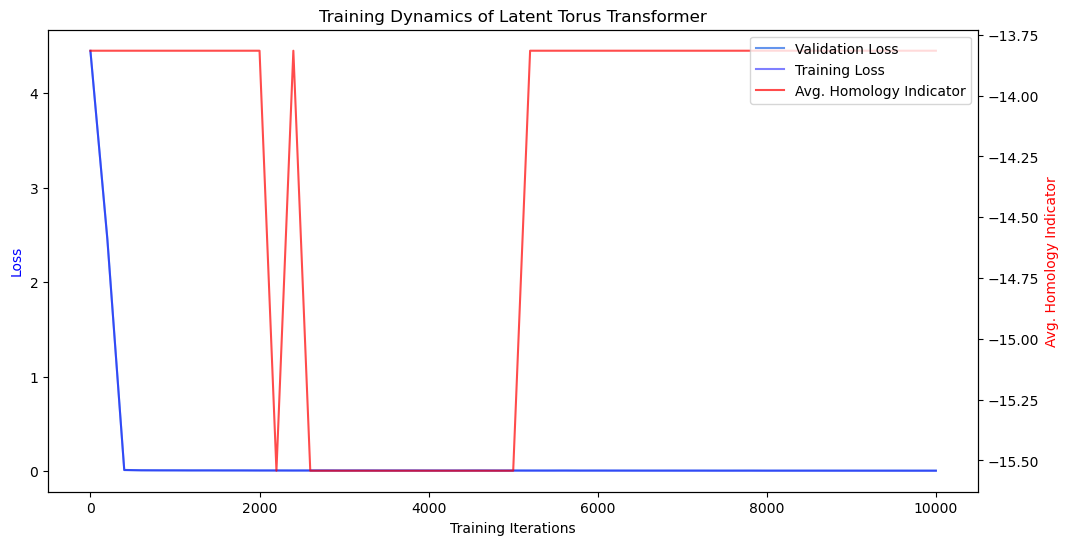

In [20]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm 
import requests

# ===================================================================
# STEP 1: 데이터 준비 (이전과 동일)
# ===================================================================
def prepare_data(device):
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    text = requests.get(url).text
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
    data = torch.tensor(encode(text), dtype=torch.long)
    n = int(0.9 * len(data))
    train_data, val_data = data[:n], data[n:]
    return train_data, val_data, vocab_size, decode

def get_batch(split, train_data, val_data, block_size, batch_size, device):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# --- 학습률 스케줄링 함수 ---
def get_lr(it, warmup_iters, learning_rate, lr_decay_iters, min_lr):
    # 1. 워밍업 (Warmup)
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2. 훈련이 끝난 후
    if it > lr_decay_iters:
        return min_lr
    # 3. 중간 감쇠 구간 (Cosine Decay)
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)

# --- 손실 평가 함수 ---
@torch.no_grad()
def estimate_loss(model, train_data, val_data, block_size, batch_size, device, eval_iters=200):
    """훈련 및 검증 손실을 여러 배치에 대해 평균내어 추정합니다."""
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, train_data, val_data, block_size, batch_size, device)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# --- 메인 훈련 및 분석 함수 (수정) ---
def train_and_monitor_language_model():
    # --- 하이퍼파라미터 ---
    n_embd, n_head, n_layer, block_size = 768, 12, 12, 256
    batch_size = 32
    max_iters = 10000
    learning_rate = 3e-4
    eval_interval = 200
    warmup_iters = 200
    lr_decay_iters = 10000
    min_lr = 3e-5
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"--- Starting Experiment on {device} ---")
    
    train_data, val_data, vocab_size, decode = prepare_data(device)
    model = LatentTorusTransformer(vocab_size, n_embd, block_size, n_head, n_layer).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    log = []
    # tqdm을 tqdm.auto에서 가져온 것으로 사용
    pbar = tqdm(range(max_iters), desc="Training Language Model")
    
    for it in pbar:
        lr = get_lr(it, warmup_iters, learning_rate, lr_decay_iters, min_lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        xb, yb = get_batch('train', train_data, val_data, block_size, batch_size, device)
        _, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        if it % eval_interval == 0 or it == max_iters - 1:
            losses = estimate_loss(model, train_data, val_data, block_size, batch_size, device)
            val_loss = losses['val']
            perplexity = math.exp(val_loss)
            
            avg_homology_indicator = 0
            # model.blocks는 Sequential이므로 직접 인덱싱
            for i in range(n_layer):
                dynamics_model = model.blocks[i].latent_dynamics
                avg_homology_indicator += run_homological_analysis(dynamics_model, device)
            avg_homology_indicator /= n_layer
            
            # log_entry에서 loss.item()을 사용하고, 키 이름을 명확히 함
            log_entry = {
                'iter': it,
                'train_loss': losses['train'], # .item()은 estimate_loss 안에서 이미 처리됨
                'val_loss': val_loss,
                'perplexity': perplexity,
                'homology_indicator': avg_homology_indicator,
                'lr': lr
            }
            log.append(log_entry)
            print(f"\nIter {it}: Val Loss={val_loss:.4f}, PPL={perplexity:.2f}, Homology Indicator={avg_homology_indicator:.4f}")

    df_log = pd.DataFrame(log)
    df_log.to_csv("lm_training_log.csv", index=False)
    
    print("\n--- Final Text Generation ---")
    context = torch.zeros((1, 1), dtype=torch.long, device=device)
    print(decode(model.generate(context, max_new_tokens=500, block_size=block_size)[0].tolist()))
    
    return df_log

# --- 시각화 함수 (수정) ---
def plot_results(log_df):
    """최종 결과 시각화"""
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    
    # KeyError 수정을 위해 'epoch' -> 'iter', 'loss' -> 'val_loss'로 변경
    ax1.plot(log_df['iter'], log_df['val_loss'], 'cornflowerblue', label='Validation Loss')
    ax1.plot(log_df['iter'], log_df['train_loss'], 'b-', alpha=0.5, label='Training Loss')
    ax2.plot(log_df['iter'], log_df['homology_indicator'], 'r-', alpha=0.7, label='Avg. Homology Indicator')
    
    ax1.set_xlabel('Training Iterations')
    ax1.set_ylabel('Loss', color='b')
    ax2.set_ylabel('Avg. Homology Indicator', color='r')
    ax1.set_title('Training Dynamics of Latent Torus Transformer')
    
    # 범례(legend)를 모아서 한 번에 표시
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.savefig("transformer_training_ekg.pdf")
    plt.show()
    
# ===================================================================
# 메인 실행부
# ===================================================================
if __name__ == '__main__':
    log_df = train_and_monitor_language_model()
    plot_results(log_df) # 결과를 시각화

In [24]:
class UnitCircleNormalization(nn.Module):
    """(cos, sin) 쌍이 단위 원 위에 있도록 정규화합니다."""
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, z):
        # z shape: (..., 4)
        # z를 두 개의 2D 벡터로 분리
        z1 = z[..., 0:2]
        z2 = z[..., 2:4]
        
        # 각 쌍을 정규화
        norm1 = torch.norm(z1, p=2, dim=-1, keepdim=True)
        norm2 = torch.norm(z2, p=2, dim=-1, keepdim=True)
        
        normalized_z1 = z1 / (norm1 + self.epsilon)
        normalized_z2 = z2 / (norm2 + self.epsilon)
        
        return torch.cat([normalized_z1, normalized_z2], dim=-1)

class EncoderV2(nn.Module):
    """고차원 상태를 2D 토러스 잠재 공간으로 인코딩 (GELU, Normalization 적용)"""
    def __init__(self, d_model):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(), # ReLU -> GELU
            nn.Linear(d_model // 2, 4)
        )
        self.normalizer = UnitCircleNormalization()

    def forward(self, x):
        return self.normalizer(self.net(x))

class LatentDynamicsV2(nn.Module):
    """토러스 잠재 공간 위에서의 동역학 (GELU, Normalization, Identity Init 적용)"""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 3072),
            nn.GELU(), # ReLU -> GELU
            nn.Linear(3072, 4)
        )
        self.normalizer = UnitCircleNormalization()
        
        # Identity 초기화: 훈련 초기에 f_tilde(z) ≈ z 가 되도록 유도
        # 마지막 레이어의 가중치를 매우 작게 초기화
        with torch.no_grad():
            self.net[-1].weight.data.uniform_(-1e-3, 1e-3)
            self.net[-1].bias.data.zero_()

    def forward(self, z):
        # 잔차 연결을 추가하여 항등 함수 학습을 도움
        return self.normalizer(z + self.net(z))

class DecoderV2(nn.Module):
    """토러스 잠재 변수를 다시 고차원 공간으로 디코딩 (GELU 적용)"""
    def __init__(self, d_model):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, d_model // 2),
            nn.GELU(), # ReLU -> GELU
            nn.Linear(d_model // 2, d_model)
        )
        # Identity 초기화: 훈련 초기에 Decoder 출력이 작아지도록 유도
        with torch.no_grad():
            self.net[-1].weight.data.uniform_(-1e-3, 1e-3)
            self.net[-1].bias.data.zero_()

    def forward(self, z):
        return self.net(z)

# ===================================================================
# STEP 3: Latent Torus Transformer V2 모델 정의
# ===================================================================

class LatentTorusTransformerBlockV2(nn.Module):
    """Pre-LayerNorm과 수정된 동역학 모듈이 적용된 V2 블록."""
    def __init__(self, n_embd, n_head):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd) # Pre-Norm
        self.sa = nn.MultiheadAttention(n_embd, n_head, batch_first=True)
        self.ln2 = nn.LayerNorm(n_embd) # Pre-Norm
        
        # V2 동역학 모듈
        self.encoder = EncoderV2(n_embd)
        self.latent_dynamics = LatentDynamicsV2()
        self.decoder = DecoderV2(n_embd)

    def forward(self, x):
        # Pre-Norm Attention
        x = x + self.sa(*[self.ln1(x)]*3)[0]
        
        # Pre-Norm Latent Torus Dynamics
        z = self.encoder(self.ln2(x))
        z_next = self.latent_dynamics(z)
        residual = self.decoder(z_next)
        x = x + residual
        
        return x
    

class LatentTorusTransformerV2(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[LatentTorusTransformerBlockV2(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits_flat = logits.view(B*T, C)
            targets_flat = targets.view(B*T)
            loss = F.cross_entropy(logits_flat, targets_flat)
            
        return logits, loss
        
    def generate(self, idx, max_new_tokens, block_size):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

    

--- Starting Experiment on cuda ---


Training Language Model:   0%|          | 1/10000 [00:27<77:42:42, 27.98s/it]


Iter 0: Val Loss=4.3180, PPL=75.04, Homology Indicator=0.0000


Training Language Model:   2%|▏         | 202/10000 [01:37<15:44:32,  5.78s/it]


Iter 200: Val Loss=2.4508, PPL=11.60, Homology Indicator=0.0000


Training Language Model:   4%|▍         | 401/10000 [02:45<22:51:08,  8.57s/it]


Iter 400: Val Loss=0.0147, PPL=1.01, Homology Indicator=0.0000


Training Language Model:   6%|▌         | 602/10000 [03:58<15:46:58,  6.05s/it]


Iter 600: Val Loss=0.0118, PPL=1.01, Homology Indicator=0.0000


Training Language Model:   8%|▊         | 801/10000 [05:09<22:27:01,  8.79s/it]


Iter 800: Val Loss=0.0109, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  10%|█         | 1002/10000 [06:19<14:39:08,  5.86s/it]


Iter 1000: Val Loss=0.0106, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  12%|█▏        | 1201/10000 [07:30<20:57:36,  8.58s/it]


Iter 1200: Val Loss=0.0104, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  14%|█▍        | 1401/10000 [08:44<21:00:32,  8.80s/it]


Iter 1400: Val Loss=0.0104, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  16%|█▌        | 1601/10000 [09:57<21:06:37,  9.05s/it]


Iter 1600: Val Loss=0.0103, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  18%|█▊        | 1802/10000 [11:12<14:10:25,  6.22s/it]


Iter 1800: Val Loss=0.0100, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  20%|██        | 2001/10000 [12:20<18:24:27,  8.28s/it]


Iter 2000: Val Loss=0.0100, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  22%|██▏       | 2201/10000 [13:29<17:52:41,  8.25s/it]


Iter 2200: Val Loss=0.0096, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  24%|██▍       | 2402/10000 [14:38<12:15:43,  5.81s/it]


Iter 2400: Val Loss=0.0097, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  26%|██▌       | 2602/10000 [15:46<11:58:09,  5.82s/it]


Iter 2600: Val Loss=0.0095, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  28%|██▊       | 2801/10000 [16:54<16:27:04,  8.23s/it]


Iter 2800: Val Loss=0.0098, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  30%|███       | 3002/10000 [18:03<11:18:50,  5.82s/it]


Iter 3000: Val Loss=0.0093, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  32%|███▏      | 3202/10000 [19:11<10:59:50,  5.82s/it]


Iter 3200: Val Loss=0.0090, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  34%|███▍      | 3402/10000 [20:19<10:40:02,  5.82s/it]


Iter 3400: Val Loss=0.0088, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  36%|███▌      | 3602/10000 [21:28<10:23:09,  5.84s/it]


Iter 3600: Val Loss=0.0095, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  38%|███▊      | 3802/10000 [22:36<10:01:36,  5.82s/it]


Iter 3800: Val Loss=0.0087, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  40%|████      | 4001/10000 [23:44<13:38:49,  8.19s/it]


Iter 4000: Val Loss=0.0087, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  42%|████▏     | 4202/10000 [24:53<9:23:02,  5.83s/it] 


Iter 4200: Val Loss=0.0089, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  44%|████▍     | 4401/10000 [26:03<13:15:18,  8.52s/it]


Iter 4400: Val Loss=0.0088, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  46%|████▌     | 4601/10000 [27:14<12:48:26,  8.54s/it]


Iter 4600: Val Loss=0.0086, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  48%|████▊     | 4801/10000 [28:25<12:18:48,  8.53s/it]


Iter 4800: Val Loss=0.0087, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  50%|█████     | 5001/10000 [29:37<12:00:44,  8.65s/it]


Iter 5000: Val Loss=0.0087, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  52%|█████▏    | 5201/10000 [30:49<11:43:50,  8.80s/it]


Iter 5200: Val Loss=0.0085, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  54%|█████▍    | 5402/10000 [32:01<7:34:10,  5.93s/it] 


Iter 5400: Val Loss=0.0085, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  56%|█████▌    | 5602/10000 [33:08<6:58:33,  5.71s/it]


Iter 5600: Val Loss=0.0084, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  58%|█████▊    | 5801/10000 [34:15<9:27:06,  8.10s/it]


Iter 5800: Val Loss=0.0083, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  60%|██████    | 6002/10000 [35:22<6:20:16,  5.71s/it]


Iter 6000: Val Loss=0.0082, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  62%|██████▏   | 6202/10000 [36:29<6:01:20,  5.71s/it]


Iter 6200: Val Loss=0.0083, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  64%|██████▍   | 6402/10000 [37:36<5:42:38,  5.71s/it]


Iter 6400: Val Loss=0.0082, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  66%|██████▌   | 6602/10000 [38:43<5:23:39,  5.72s/it]


Iter 6600: Val Loss=0.0080, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  68%|██████▊   | 6801/10000 [39:50<7:10:55,  8.08s/it]


Iter 6800: Val Loss=0.0080, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  70%|███████   | 7001/10000 [40:57<6:44:05,  8.08s/it]


Iter 7000: Val Loss=0.0080, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  72%|███████▏  | 7202/10000 [42:04<4:26:36,  5.72s/it]


Iter 7200: Val Loss=0.0080, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  74%|███████▍  | 7402/10000 [43:11<4:07:35,  5.72s/it]


Iter 7400: Val Loss=0.0078, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  76%|███████▌  | 7602/10000 [44:18<3:48:05,  5.71s/it]


Iter 7600: Val Loss=0.0079, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  78%|███████▊  | 7801/10000 [45:25<4:55:40,  8.07s/it]


Iter 7800: Val Loss=0.0077, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  80%|████████  | 8002/10000 [46:32<3:10:09,  5.71s/it]


Iter 8000: Val Loss=0.0076, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  82%|████████▏ | 8202/10000 [47:39<2:51:00,  5.71s/it]


Iter 8200: Val Loss=0.0076, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  84%|████████▍ | 8402/10000 [48:46<2:31:57,  5.71s/it]


Iter 8400: Val Loss=0.0076, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  86%|████████▌ | 8601/10000 [49:53<3:08:10,  8.07s/it]


Iter 8600: Val Loss=0.0076, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  88%|████████▊ | 8802/10000 [51:00<1:54:00,  5.71s/it]


Iter 8800: Val Loss=0.0076, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  90%|█████████ | 9002/10000 [52:07<1:34:59,  5.71s/it]


Iter 9000: Val Loss=0.0075, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  92%|█████████▏| 9201/10000 [53:14<1:47:34,  8.08s/it]


Iter 9200: Val Loss=0.0075, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  94%|█████████▍| 9402/10000 [54:21<56:55,  5.71s/it]  


Iter 9400: Val Loss=0.0074, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  96%|█████████▌| 9602/10000 [55:28<37:55,  5.72s/it]


Iter 9600: Val Loss=0.0075, PPL=1.01, Homology Indicator=0.0000


Training Language Model:  98%|█████████▊| 9802/10000 [56:35<18:52,  5.72s/it]


Iter 9800: Val Loss=0.0074, PPL=1.01, Homology Indicator=0.0000


Training Language Model: 100%|██████████| 10000/10000 [57:41<00:00,  2.89it/s]


Iter 9999: Val Loss=0.0073, PPL=1.01, Homology Indicator=0.0000

--- Final Text Generation ---



!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'!!!!!!!!!!!,!!!!!!!!!!!!!!!!!!!!!!!!!!!!O!!!!!!!!!!!!!!!!!!!!,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!Z!!!!!!!!!!!!!!!-!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!i!!,!!!!U!!!!!S!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!Z!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


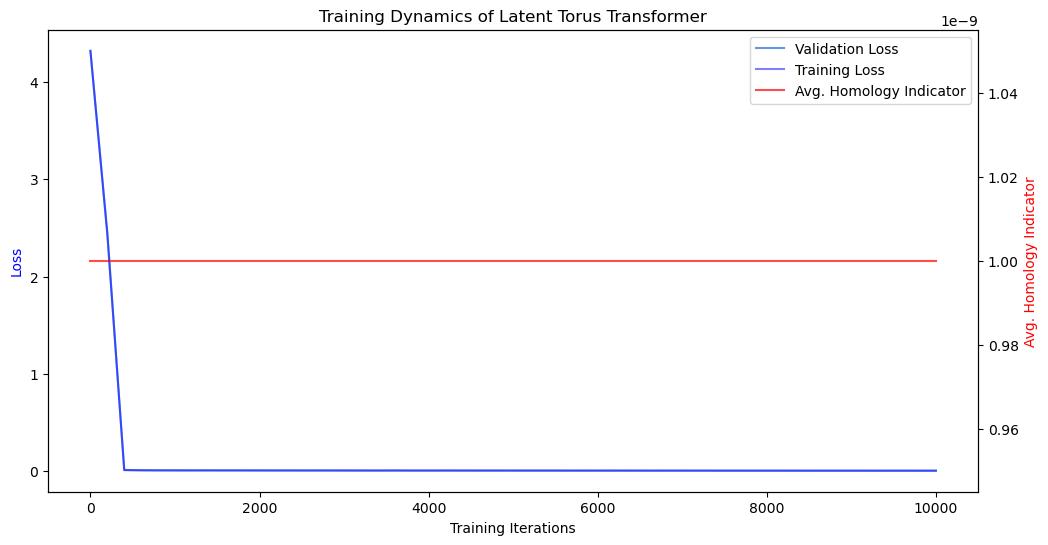

In [25]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm 
import requests

# ===================================================================
# STEP 1: 데이터 준비 (이전과 동일)
# ===================================================================
def prepare_data(device):
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    text = requests.get(url).text
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
    data = torch.tensor(encode(text), dtype=torch.long)
    n = int(0.9 * len(data))
    train_data, val_data = data[:n], data[n:]
    return train_data, val_data, vocab_size, decode

def get_batch(split, train_data, val_data, block_size, batch_size, device):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# --- 학습률 스케줄링 함수 ---
def get_lr(it, warmup_iters, learning_rate, lr_decay_iters, min_lr):
    # 1. 워밍업 (Warmup)
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2. 훈련이 끝난 후
    if it > lr_decay_iters:
        return min_lr
    # 3. 중간 감쇠 구간 (Cosine Decay)
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)

# --- 손실 평가 함수 ---
@torch.no_grad()
def estimate_loss(model, train_data, val_data, block_size, batch_size, device, eval_iters=200):
    """훈련 및 검증 손실을 여러 배치에 대해 평균내어 추정합니다."""
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, train_data, val_data, block_size, batch_size, device)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# --- 메인 훈련 및 분석 함수 (수정) ---
def train_and_monitor_language_model():
    # --- 하이퍼파라미터 ---
    n_embd, n_head, n_layer, block_size = 768, 12, 12, 256
    batch_size = 32
    max_iters = 10000
    learning_rate = 3e-4
    eval_interval = 200
    warmup_iters = 200
    lr_decay_iters = 10000
    min_lr = 3e-5
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"--- Starting Experiment on {device} ---")
    
    train_data, val_data, vocab_size, decode = prepare_data(device)
    model = LatentTorusTransformerV2(vocab_size, n_embd, block_size, n_head, n_layer).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    log = []
    # tqdm을 tqdm.auto에서 가져온 것으로 사용
    pbar = tqdm(range(max_iters), desc="Training Language Model")
    
    for it in pbar:
        lr = get_lr(it, warmup_iters, learning_rate, lr_decay_iters, min_lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        xb, yb = get_batch('train', train_data, val_data, block_size, batch_size, device)
        _, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        if it % eval_interval == 0 or it == max_iters - 1:
            losses = estimate_loss(model, train_data, val_data, block_size, batch_size, device)
            val_loss = losses['val']
            perplexity = math.exp(val_loss)
            
            avg_homology_indicator = 0
            # model.blocks는 Sequential이므로 직접 인덱싱
            for i in range(n_layer):
                dynamics_model = model.blocks[i].latent_dynamics
                avg_homology_indicator += run_homological_analysis(dynamics_model, device)
            avg_homology_indicator /= n_layer
            
            # log_entry에서 loss.item()을 사용하고, 키 이름을 명확히 함
            log_entry = {
                'iter': it,
                'train_loss': losses['train'], # .item()은 estimate_loss 안에서 이미 처리됨
                'val_loss': val_loss,
                'perplexity': perplexity,
                'homology_indicator': avg_homology_indicator,
                'lr': lr
            }
            log.append(log_entry)
            print(f"\nIter {it}: Val Loss={val_loss:.4f}, PPL={perplexity:.2f}, Homology Indicator={avg_homology_indicator:.4f}")

    df_log = pd.DataFrame(log)
    df_log.to_csv("lm_training_log.csv", index=False)
    
    print("\n--- Final Text Generation ---")
    context = torch.zeros((1, 1), dtype=torch.long, device=device)
    print(decode(model.generate(context, max_new_tokens=500, block_size=block_size)[0].tolist()))
    
    return df_log

# --- 시각화 함수 (수정) ---
def plot_results(log_df):
    """최종 결과 시각화"""
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    
    # KeyError 수정을 위해 'epoch' -> 'iter', 'loss' -> 'val_loss'로 변경
    ax1.plot(log_df['iter'], log_df['val_loss'], 'cornflowerblue', label='Validation Loss')
    ax1.plot(log_df['iter'], log_df['train_loss'], 'b-', alpha=0.5, label='Training Loss')
    ax2.plot(log_df['iter'], log_df['homology_indicator'], 'r-', alpha=0.7, label='Avg. Homology Indicator')
    
    ax1.set_xlabel('Training Iterations')
    ax1.set_ylabel('Loss', color='b')
    ax2.set_ylabel('Avg. Homology Indicator', color='r')
    ax1.set_title('Training Dynamics of Latent Torus Transformer')
    
    # 범례(legend)를 모아서 한 번에 표시
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.savefig("transformer_training_ekg.pdf")
    plt.show()
    
# ===================================================================
# 메인 실행부
# ===================================================================
if __name__ == '__main__':
    log_df = train_and_monitor_language_model()
    plot_results(log_df) # 결과를 시각화

In [26]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import requests

# ===================================================================
# 데이터 준비 및 훈련 유틸리티 (이전과 동일)
# ... prepare_data, get_batch, get_lr, estimate_loss ...
# ===================================================================
def prepare_data(device):
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    text = requests.get(url).text
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
    data = torch.tensor(encode(text), dtype=torch.long)
    n = int(0.9 * len(data))
    train_data, val_data = data[:n], data[n:]
    return train_data, val_data, vocab_size, decode

def get_batch(split, train_data, val_data, block_size, batch_size, device):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# --- 학습률 스케줄링 함수 ---
def get_lr(it, warmup_iters, learning_rate, lr_decay_iters, min_lr):
    # 1. 워밍업 (Warmup)
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2. 훈련이 끝난 후
    if it > lr_decay_iters:
        return min_lr
    # 3. 중간 감쇠 구간 (Cosine Decay)
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)

# --- 손실 평가 함수 ---
@torch.no_grad()
def estimate_loss(model, train_data, val_data, block_size, batch_size, device, eval_iters=200):
    """훈련 및 검증 손실을 여러 배치에 대해 평균내어 추정합니다."""
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, train_data, val_data, block_size, batch_size, device)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


# ===================================================================
# STEP 1: 표준 트랜스포머 블록 및 모델 정의 (NanoLM-style)
# ===================================================================

class FeedForward(nn.Module):
    """A simple linear layer followed by a non-linearity"""
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), # 차원 확장 (768 -> 3072)
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd), # 다시 원래 차원으로 축소
        )

    def forward(self, x):
        return self.net(x)

class StandardTransformerBlock(nn.Module):
    """Standard Transformer block with Pre-LayerNorm."""
    def __init__(self, n_embd, n_head):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.sa = nn.MultiheadAttention(n_embd, n_head, batch_first=True)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ffwd = FeedForward(n_embd)

    def forward(self, x):
        # Pre-Norm Attention
        x = x + self.sa(*[self.ln1(x)]*3)[0]
        # Pre-Norm Feed-Forward Network
        x = x + self.ffwd(self.ln2(x))
        return x

class StandardTransformer(nn.Module):
    """A standard Transformer model (NanoLM-style)."""
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer):
        super().__init__()
        self.block_size = block_size
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[StandardTransformerBlock(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits_flat = logits.view(B*T, C)
            targets_flat = targets.view(B*T)
            loss = F.cross_entropy(logits_flat, targets_flat)
            
        return logits, loss
        
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# ===================================================================
# STEP 2: 훈련 파이프라인 (분석 부분 제외)
# ===================================================================
def train_standard_transformer():
    # --- 하이퍼파라미터 (우리 모델과 동일하게 설정) ---
    n_embd, n_head, n_layer, block_size = 768, 12, 12, 256
    batch_size = 32
    max_iters = 10000
    learning_rate = 3e-4
    eval_interval = 200
    warmup_iters = 200
    lr_decay_iters = 10000
    min_lr = 3e-5
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"--- Starting Standard Transformer Training on {device} ---")
    
    train_data, val_data, vocab_size, decode = prepare_data(device)
    # 우리 모델 대신 StandardTransformer를 사용
    model = StandardTransformer(vocab_size, n_embd, block_size, n_head, n_layer).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    pbar = tqdm(range(max_iters), desc="Training Standard Transformer")
    
    for it in pbar:
        lr = get_lr(it, warmup_iters, learning_rate, lr_decay_iters, min_lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        xb, yb = get_batch('train', train_data, val_data, block_size, batch_size, device)
        _, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        if it % eval_interval == 0 or it == max_iters - 1:
            losses = estimate_loss(model, train_data, val_data, block_size, batch_size, device)
            val_loss = losses['val']
            perplexity = math.exp(val_loss)
            print(f"\nIter {it}: Val Loss={val_loss:.4f}, PPL={perplexity:.2f}")

    print("\n--- Final Text Generation (Standard Transformer) ---")
    context = torch.zeros((1, 1), dtype=torch.long, device=device)
    print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))

# ===================================================================
# 메인 실행부
# ===================================================================
if __name__ == '__main__':
    # 여기에 이전 코드의 유틸리티 함수 정의를 붙여넣으세요.
    # prepare_data, get_batch, get_lr, estimate_loss
    # ...
    train_standard_transformer()

--- Starting Standard Transformer Training on cuda ---


Training Standard Transformer:   0%|          | 1/10000 [00:45<127:42:50, 45.98s/it]


Iter 0: Val Loss=4.3020, PPL=73.85


Training Standard Transformer:   2%|▏         | 201/10000 [02:39<38:07:55, 14.01s/it]


Iter 200: Val Loss=2.3729, PPL=10.73


Training Standard Transformer:   4%|▍         | 401/10000 [04:33<37:26:35, 14.04s/it]


Iter 400: Val Loss=0.0134, PPL=1.01


Training Standard Transformer:   6%|▌         | 601/10000 [06:26<36:41:16, 14.05s/it]


Iter 600: Val Loss=0.0118, PPL=1.01


Training Standard Transformer:   8%|▊         | 801/10000 [08:20<35:55:34, 14.06s/it]


Iter 800: Val Loss=0.0113, PPL=1.01


Training Standard Transformer:  10%|█         | 1001/10000 [10:16<36:04:10, 14.43s/it]


Iter 1000: Val Loss=0.0107, PPL=1.01


Training Standard Transformer:  12%|█▏        | 1201/10000 [12:07<33:25:06, 13.67s/it]


Iter 1200: Val Loss=0.0099, PPL=1.01


Training Standard Transformer:  14%|█▍        | 1401/10000 [13:57<32:36:22, 13.65s/it]


Iter 1400: Val Loss=0.0102, PPL=1.01


Training Standard Transformer:  16%|█▌        | 1601/10000 [15:47<31:54:24, 13.68s/it]


Iter 1600: Val Loss=0.0101, PPL=1.01


Training Standard Transformer:  18%|█▊        | 1801/10000 [17:37<31:08:32, 13.67s/it]


Iter 1800: Val Loss=0.0098, PPL=1.01


Training Standard Transformer:  20%|██        | 2001/10000 [19:27<30:23:02, 13.67s/it]


Iter 2000: Val Loss=0.0098, PPL=1.01


Training Standard Transformer:  22%|██▏       | 2201/10000 [21:17<29:36:38, 13.67s/it]


Iter 2200: Val Loss=0.0095, PPL=1.01


Training Standard Transformer:  24%|██▍       | 2401/10000 [23:08<28:52:18, 13.68s/it]


Iter 2400: Val Loss=0.0094, PPL=1.01


Training Standard Transformer:  26%|██▌       | 2601/10000 [24:58<28:05:03, 13.66s/it]


Iter 2600: Val Loss=0.0092, PPL=1.01


Training Standard Transformer:  28%|██▊       | 2801/10000 [26:48<27:14:27, 13.62s/it]


Iter 2800: Val Loss=0.0090, PPL=1.01


Training Standard Transformer:  30%|███       | 3001/10000 [28:38<26:27:39, 13.61s/it]


Iter 3000: Val Loss=0.0092, PPL=1.01


Training Standard Transformer:  32%|███▏      | 3201/10000 [30:28<25:42:05, 13.61s/it]


Iter 3200: Val Loss=0.0092, PPL=1.01


Training Standard Transformer:  34%|███▍      | 3401/10000 [32:18<24:59:23, 13.63s/it]


Iter 3400: Val Loss=0.0088, PPL=1.01


Training Standard Transformer:  36%|███▌      | 3601/10000 [34:08<24:12:58, 13.62s/it]


Iter 3600: Val Loss=0.0090, PPL=1.01


Training Standard Transformer:  38%|███▊      | 3801/10000 [35:58<23:27:27, 13.62s/it]


Iter 3800: Val Loss=0.0089, PPL=1.01


Training Standard Transformer:  40%|████      | 4001/10000 [37:48<22:41:33, 13.62s/it]


Iter 4000: Val Loss=0.0092, PPL=1.01


Training Standard Transformer:  42%|████▏     | 4201/10000 [39:37<21:55:59, 13.62s/it]


Iter 4200: Val Loss=0.0087, PPL=1.01


Training Standard Transformer:  44%|████▍     | 4401/10000 [41:27<21:11:31, 13.63s/it]


Iter 4400: Val Loss=0.0089, PPL=1.01


Training Standard Transformer:  46%|████▌     | 4601/10000 [43:17<20:25:38, 13.62s/it]


Iter 4600: Val Loss=0.0087, PPL=1.01


Training Standard Transformer:  48%|████▊     | 4801/10000 [45:07<19:42:29, 13.65s/it]


Iter 4800: Val Loss=0.0087, PPL=1.01


Training Standard Transformer:  50%|█████     | 5001/10000 [46:56<18:56:24, 13.64s/it]


Iter 5000: Val Loss=0.0086, PPL=1.01


Training Standard Transformer:  52%|█████▏    | 5201/10000 [48:47<18:28:28, 13.86s/it]


Iter 5200: Val Loss=0.0091, PPL=1.01


Training Standard Transformer:  54%|█████▍    | 5401/10000 [50:38<17:27:05, 13.66s/it]


Iter 5400: Val Loss=0.0087, PPL=1.01


Training Standard Transformer:  56%|█████▌    | 5601/10000 [52:28<16:41:26, 13.66s/it]


Iter 5600: Val Loss=0.0085, PPL=1.01


Training Standard Transformer:  58%|█████▊    | 5801/10000 [54:18<15:57:14, 13.68s/it]


Iter 5800: Val Loss=0.0084, PPL=1.01


Training Standard Transformer:  60%|██████    | 6001/10000 [56:08<15:11:30, 13.68s/it]


Iter 6000: Val Loss=0.0082, PPL=1.01


Training Standard Transformer:  62%|██████▏   | 6201/10000 [57:58<14:26:27, 13.68s/it]


Iter 6200: Val Loss=0.0083, PPL=1.01


Training Standard Transformer:  64%|██████▍   | 6401/10000 [59:50<13:50:48, 13.85s/it]


Iter 6400: Val Loss=0.0082, PPL=1.01


Training Standard Transformer:  66%|██████▌   | 6601/10000 [1:01:42<12:54:54, 13.68s/it]


Iter 6600: Val Loss=0.0082, PPL=1.01


Training Standard Transformer:  68%|██████▊   | 6801/10000 [1:03:33<12:09:32, 13.68s/it]


Iter 6800: Val Loss=0.0082, PPL=1.01


Training Standard Transformer:  70%|███████   | 7001/10000 [1:05:24<11:23:22, 13.67s/it]


Iter 7000: Val Loss=0.0081, PPL=1.01


Training Standard Transformer:  72%|███████▏  | 7201/10000 [1:07:14<10:37:34, 13.67s/it]


Iter 7200: Val Loss=0.0080, PPL=1.01


Training Standard Transformer:  74%|███████▍  | 7401/10000 [1:09:04<9:50:53, 13.64s/it] 


Iter 7400: Val Loss=0.0081, PPL=1.01


Training Standard Transformer:  76%|███████▌  | 7601/10000 [1:10:54<9:05:27, 13.64s/it]


Iter 7600: Val Loss=0.0079, PPL=1.01


Training Standard Transformer:  78%|███████▊  | 7801/10000 [1:12:44<8:20:07, 13.65s/it]


Iter 7800: Val Loss=0.0078, PPL=1.01


Training Standard Transformer:  80%|████████  | 8001/10000 [1:14:33<7:34:39, 13.65s/it]


Iter 8000: Val Loss=0.0078, PPL=1.01


Training Standard Transformer:  82%|████████▏ | 8201/10000 [1:16:23<6:48:49, 13.63s/it]


Iter 8200: Val Loss=0.0076, PPL=1.01


Training Standard Transformer:  84%|████████▍ | 8401/10000 [1:18:13<6:03:28, 13.64s/it]


Iter 8400: Val Loss=0.0079, PPL=1.01


Training Standard Transformer:  86%|████████▌ | 8601/10000 [1:20:03<5:19:55, 13.72s/it]


Iter 8600: Val Loss=0.0079, PPL=1.01


Training Standard Transformer:  88%|████████▊ | 8801/10000 [1:21:54<4:33:01, 13.66s/it]


Iter 8800: Val Loss=0.0076, PPL=1.01


Training Standard Transformer:  90%|█████████ | 9001/10000 [1:23:44<3:47:25, 13.66s/it]


Iter 9000: Val Loss=0.0076, PPL=1.01


Training Standard Transformer:  92%|█████████▏| 9201/10000 [1:25:34<3:01:50, 13.66s/it]


Iter 9200: Val Loss=0.0078, PPL=1.01


Training Standard Transformer:  94%|█████████▍| 9401/10000 [1:27:25<2:16:15, 13.65s/it]


Iter 9400: Val Loss=0.0074, PPL=1.01


Training Standard Transformer:  96%|█████████▌| 9601/10000 [1:29:15<1:30:39, 13.63s/it]


Iter 9600: Val Loss=0.0075, PPL=1.01


Training Standard Transformer:  98%|█████████▊| 9801/10000 [1:31:05<45:15, 13.65s/it]  


Iter 9800: Val Loss=0.0075, PPL=1.01


Training Standard Transformer: 100%|██████████| 10000/10000 [1:32:55<00:00,  1.79it/s]



Iter 9999: Val Loss=0.0076, PPL=1.01

--- Final Text Generation (Standard Transformer) ---



?

?
Sa
S




















S
ta










C


ow
























St



















S




P



O

!




P
?

?
S
X?

SS
OX


!


OX
?


?
?


!



?







SOmb



!
!
?

S
S
O






?
a




?
?
?
o?
S!
Sheah

?
?
!


?

?
!

?
!
P
SS!
?
Save? easlooh velly! what a him his have elhone the pispor a'ts: lentaw'
? dau a shalral
Yex? a all: are of me mo?
where the hope love:
May pisstand of not shalk yee.

KING LE:
Tho which thin: that he rine a of this good have noh he; respost of G


--- Starting Experiment on cuda ---
Total Parameters: 3.50M


Iter 19999: Val Loss=0.8779, PPL=2.41, Homology Score=-10.3616: 100%|██████████| 20000/20000 [18:42<00:00, 17.82it/s]   



--- Final Text Generation ---


















 
 
H

L

M




EEU





R


G

C



ELEE
R
HEeLO
N
Bl Ls H
e
ES
P
.h
HEE: MDWr
Ho:iRo  IoHKet Rt:h o Cl Pt
 Te

e rKn:oueuu
Omeidy d ioEicUoUo oIT:  goeWit 
nv  tn:d nthgdrto bblyd,e t ecfo oe feg 

l Eul  uneddh gosnf.uih aTop dtteribh dt bs t ye 
s gr, s
on dt,d ibnmiaee e tryaat  -om erOayeEt gae g
 tsoaa, ph ehoein t,o Hat lToHty hotrofae rti
e oeh ei hle uta 
uh ui ,ehthteyC
or 
ft o  p wg ehe aikos moy oT u c e
h ta id wyS
it .lehe 
mt d
dl,rs cruseaRynt t nowoCt, syhsraPero
p  Bd
raVoeranct sroOr  ri Csam ply trSmdu toG
uw U od d lnc, dleea a cbh fodid i nrIh! f ee

a a o tdn  ce simse thht th  u hi nrIrr e  yoITms onthptL doniekaud:leohiH rd e the owthrv Loos Akth
he ft , Ifd nMh we Lh l en eefwih eLhn,.cge u
d w ethlr dseyon Pkarllriuuhe
cn    l gt gep dd t
t o rn,he oeN k hihrLm isrhsau n  it neglrithoh oineshiNhs  s s e'em naoiso rfe ii neaps th p nmethe ols e  o W
mlt   e o h i br eaS bn
htnWn f heo  rof Ir, i  naldehor 
si 

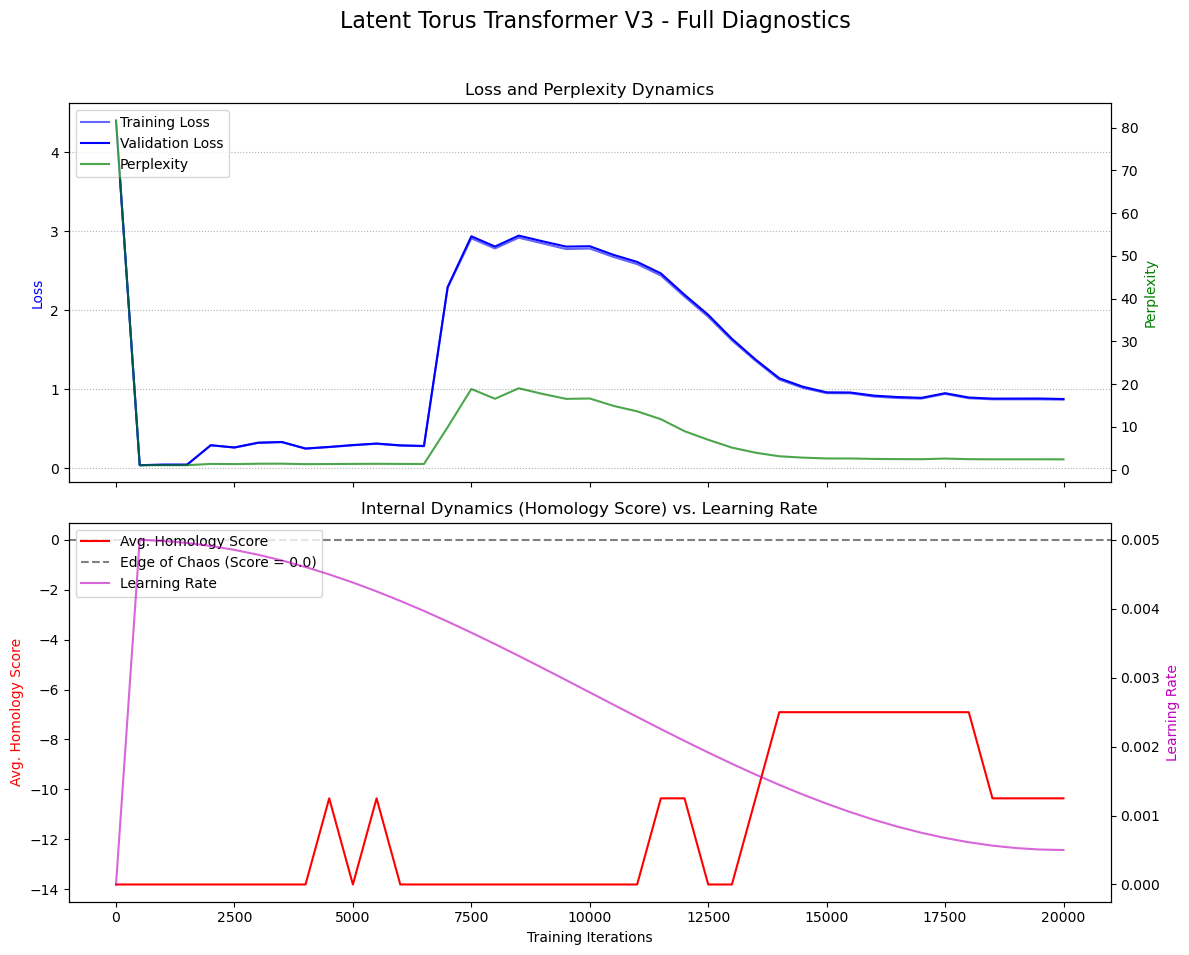

In [27]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import requests
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import warnings

# ===================================================================
# STEP 1: 데이터 및 하이퍼파라미터 (nanolm.ipynb 참조)
# ===================================================================

# --- 하이퍼파라미터 ---
BATCH_SIZE = 128
BLOCK_SIZE = 64
MAX_ITERS = 20000
EVAL_INTERVAL = 500
LEARNING_RATE = 5e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EVAL_ITERS = 200
N_EMBD = 256
N_HEAD = 8
N_LAYER = 6
DROPOUT = 0.2

# 코사인 학습률 스케줄러 파라미터
WARMUP_ITERS = 200
LR_DECAY_ITERS = 20000
MIN_LR = 5e-4

# --- 데이터 준비 ---
def prepare_data(device):
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    text = requests.get(url).text
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
    data = torch.tensor(encode(text), dtype=torch.long)
    n = int(0.9 * len(data))
    train_data, val_data = data[:n], data[n:]
    return train_data, val_data, vocab_size, decode

def get_batch(split, train_data, val_data, block_size, batch_size, device):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# ===================================================================
# STEP 2: 모델 아키텍처 정의 (V3 - Direct 4D Dynamics)
# ===================================================================
# (이전 답변과 동일한 모델 아키텍처 V3를 사용합니다)

class UnitCircleNormalization(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, z):
        z1, z2 = z[..., 0:2], z[..., 2:4]
        norm1 = torch.norm(z1, p=2, dim=-1, keepdim=True)
        norm2 = torch.norm(z2, p=2, dim=-1, keepdim=True)
        normalized_z1 = z1 / (norm1 + self.epsilon)
        normalized_z2 = z2 / (norm2 + self.epsilon)
        return torch.cat([normalized_z1, normalized_z2], dim=-1)

class EncoderV3(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_model // 2), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_model // 2, 4)
        )
        self.normalizer = UnitCircleNormalization()

    def forward(self, x):
        return self.normalizer(self.net(x))

class LatentDynamicsDirect4D(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 1024), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(1024, 4)
        )
        self.normalizer = UnitCircleNormalization()
        with torch.no_grad():
            self.net[-1].weight.data.zero_()
            for i in range(4): self.net[-1].weight.data[i, i] = 1.0
            self.net[-1].bias.data.zero_()

    def forward(self, z):
        return self.normalizer(self.net(z))

class DecoderV3(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 4 * d_model), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(4 * d_model, d_model)
        )

    def forward(self, z):
        return self.net(z)

class LatentTorusTransformerBlockV3(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.sa = nn.MultiheadAttention(n_embd, n_head, dropout=dropout, batch_first=True)
        self.ln2 = nn.LayerNorm(n_embd)
        self.encoder = EncoderV3(n_embd, dropout)
        self.latent_dynamics = LatentDynamicsDirect4D(dropout)
        self.decoder = DecoderV3(n_embd, dropout)

    def forward(self, x):
        x = x + self.sa(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        norm_x = self.ln2(x)
        z = self.encoder(norm_x)
        z_next = self.latent_dynamics(z)
        residual = self.decoder(z_next)
        x = x + residual
        return x

class LatentTorusTransformerV3(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer, dropout):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[LatentTorusTransformerBlockV3(n_embd, n_head, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=DEVICE))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss
    
    def generate(self, idx, max_new_tokens, block_size, temperature=0.8):
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        self.train()
        return idx

# ===================================================================
# STEP 3: Homology 분석 및 훈련 로직 (사용자 제공 코드로 교체)
# ===================================================================

def run_homological_analysis(
    dynamics_model, device,
    n_points=2000, tol=0.2
):
    """
    Returns (M, score) or raises unexpected exceptions.
    M: 2×2 int matrix of induced map
    score: log spectral radius
    """
    dynamics_model.eval()
    t = torch.linspace(0, 2*np.pi, n_points, device=device)
    # (cos, sin) 표현을 직접 사용
    loop1 = torch.stack([torch.cos(t), torch.sin(t), 
                         torch.ones_like(t), torch.zeros_like(t)], dim=1)
    loop2 = torch.stack([torch.ones_like(t), torch.zeros_like(t), 
                         torch.cos(t), torch.sin(t)], dim=1)

    transformed_loops_angle = []
    with torch.no_grad():
        for loop_trig in [loop1, loop2]:
            transformed_trig = dynamics_model(loop_trig)
            cos1, sin1, cos2, sin2 = transformed_trig.T
            theta_out = torch.atan2(sin1, cos1)
            p_out     = torch.atan2(sin2, cos2)
            transformed_loops_angle.append(
                torch.stack([theta_out, p_out], dim=1).cpu().numpy()
            )
            
    M = np.zeros((2, 2), dtype=int)
    for i, loop in enumerate(transformed_loops_angle):
        # loop: shape (n_points, 2)
        unwrapped = np.unwrap(loop, axis=0)
        raw_windings = (unwrapped[-1] - unwrapped[0]) / (2 * np.pi)
        approx_windings = np.round(raw_windings).astype(int)

        # tol 이상 차이나면 경고만 남기고 보정값 사용
        mask = ~np.isclose(raw_windings, approx_windings, atol=tol)
        if np.any(mask):
            warnings.warn(
                f"Winding deviation {raw_windings[mask]} exceeds tol={tol}, "
                f"using nearest ints {approx_windings[mask]}",
                UserWarning
            )

        M[:, i] = approx_windings

    eigs = np.linalg.eigvals(M)
    score = np.log(np.max(np.abs(eigs)) + 1e-9)
    # 훈련 루프에서 score를 사용하기 위해 M과 함께 반환
    return M, score

@torch.no_grad()
def estimate_loss(model, train_data, val_data, block_size, batch_size, device, eval_iters):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, train_data, val_data, block_size, batch_size, device)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def get_lr(it):
    if it < WARMUP_ITERS: return LEARNING_RATE * it / WARMUP_ITERS
    if it > LR_DECAY_ITERS: return MIN_LR
    decay_ratio = (it - WARMUP_ITERS) / (LR_DECAY_ITERS - WARMUP_ITERS)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return MIN_LR + coeff * (LEARNING_RATE - MIN_LR)

# ===================================================================
# STEP 4: 메인 훈련 및 분석 함수 (수정)
# ===================================================================

def train_and_monitor_model():
    print(f"--- Starting Experiment on {DEVICE} ---")
    
    train_data, val_data, vocab_size, decode = prepare_data(DEVICE)
    model = LatentTorusTransformerV3(vocab_size, N_EMBD, BLOCK_SIZE, N_HEAD, N_LAYER, DROPOUT).to(DEVICE)
    print(f"Total Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    log = []
    pbar = tqdm(range(MAX_ITERS))
    
    for it in pbar:
        lr = get_lr(it)
        for param_group in optimizer.param_groups: param_group['lr'] = lr
        xb, yb = get_batch('train', train_data, val_data, BLOCK_SIZE, BATCH_SIZE, DEVICE)
        _, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        if it % EVAL_INTERVAL == 0 or it == MAX_ITERS - 1:
            losses = estimate_loss(model, train_data, val_data, BLOCK_SIZE, BATCH_SIZE, DEVICE, EVAL_ITERS)
            val_loss = losses['val']
            perplexity = math.exp(val_loss) if val_loss < 20 else float('inf')
            
            avg_homology_score = 0
            for i in range(N_LAYER):
                dynamics_model = model.blocks[i].latent_dynamics
                # score 값만 가져와서 사용
                _, score = run_homological_analysis(dynamics_model, DEVICE)
                avg_homology_score += score
            avg_homology_score /= N_LAYER
            
            log_entry = {'iter': it, 'train_loss': losses['train'], 'val_loss': val_loss,
                         'perplexity': perplexity, 'homology_indicator': avg_homology_score, 'lr': lr}
            log.append(log_entry)
            pbar.set_description(f"Iter {it}: Val Loss={val_loss:.4f}, PPL={perplexity:.2f}, Homology Score={avg_homology_score:.4f}")

    df_log = pd.DataFrame(log)
    
    print("\n--- Final Text Generation ---")
    context = torch.zeros((1, 1), dtype=torch.long, device=DEVICE)
    generated_text = decode(model.generate(context, max_new_tokens=1000, block_size=BLOCK_SIZE)[0].tolist())
    print(generated_text)
    
    return df_log

# ===================================================================
# STEP 5: 종합 시각화 함수 (수정)
# ===================================================================

def plot_full_diagnostics(log_df):
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    fig.suptitle('Latent Torus Transformer V3 - Full Diagnostics', fontsize=16)

    # --- 상단 패널: 손실 및 복잡도 ---
    ax2 = ax1.twinx()
    ax1.plot(log_df['iter'], log_df['train_loss'], 'b-', alpha=0.6, label='Training Loss')
    ax1.plot(log_df['iter'], log_df['val_loss'], 'b-', alpha=1.0, label='Validation Loss')
    ax2.plot(log_df['iter'], log_df['perplexity'], 'g-', alpha=0.7, label='Perplexity')
    ax1.set_ylabel('Loss', color='b')
    ax2.set_ylabel('Perplexity', color='g')
    ax1.set_title('Loss and Perplexity Dynamics')
    ax1.grid(True, axis='y', linestyle=':')
    
    # --- 하단 패널: Homology 점수 및 학습률 ---
    ax4 = ax3.twinx()
    ax3.plot(log_df['iter'], log_df['homology_indicator'], 'r-', alpha=1.0, label='Avg. Homology Score')
    # score는 log(spectral_radius)이므로, Edge of Chaos는 0.0
    ax3.axhline(y=0.0, color='grey', linestyle='--', label='Edge of Chaos (Score = 0.0)')
    ax4.plot(log_df['iter'], log_df['lr'], 'm-', alpha=0.6, label='Learning Rate')
    ax3.set_xlabel('Training Iterations')
    ax3.set_ylabel('Avg. Homology Score', color='r')
    ax4.set_ylabel('Learning Rate', color='m')
    ax3.set_title('Internal Dynamics (Homology Score) vs. Learning Rate')
    
    # 범례 모으기
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    lines3, labels3 = ax3.get_legend_handles_labels()
    lines4, labels4 = ax4.get_legend_handles_labels()
    ax3.legend(lines3 + lines4, labels3 + labels4, loc='upper left')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig("v3_full_diagnostics.pdf")
    plt.show()

# ===================================================================
# STEP 6: 메인 실행부
# ===================================================================

if __name__ == '__main__':
    log_df = train_and_monitor_model()
    if not log_df.empty:
        plot_full_diagnostics(log_df)

--- Starting Experiment on cuda ---
Total Parameters: 3.50M


Iter 19999: Val Loss=0.0363, PPL=1.04: 100%|██████████| 20000/20000 [19:09<00:00, 17.40it/s]  



--- Final Text Generation ---
































































ORT:
Al:
I sher if If so.

Und trestith sun shy pis fotey,
As his thar dowe Jot, wo gome non theray ham yom ans cower the fory no sior wors marl Mand: tht thim to bir awn iver it agheap, hat Nout mert tou braigh and hiuse werd hele:
Heg romrr I hius coreagiy hithe rat mareer tonderd,
Wist ploutle an thand ce wor ehe kithe powe in whed me now pould stare son then mar wour, far wae, is noow I lou thespakrichar, se-pis yonesarsver at oregt trer mar me and rireasy dortt noler his sht mur wat bee fof th towk
An chade 'it heers,
Your thele ifncan theell warcas larg my nowe theplo wot er met noetind maltid yorfong's all to sess sou'chis mome yos do nod whaghell ching ut have.

Bubnd yokice brot the tos cint ance, cicay and se de ghirst ane le hand bun th cu in Corit sond the checie rouvef the but mous ante sit, co bousct I of his herecears Mad hir the us cis asd me yens of im sh win I th ale pleathe

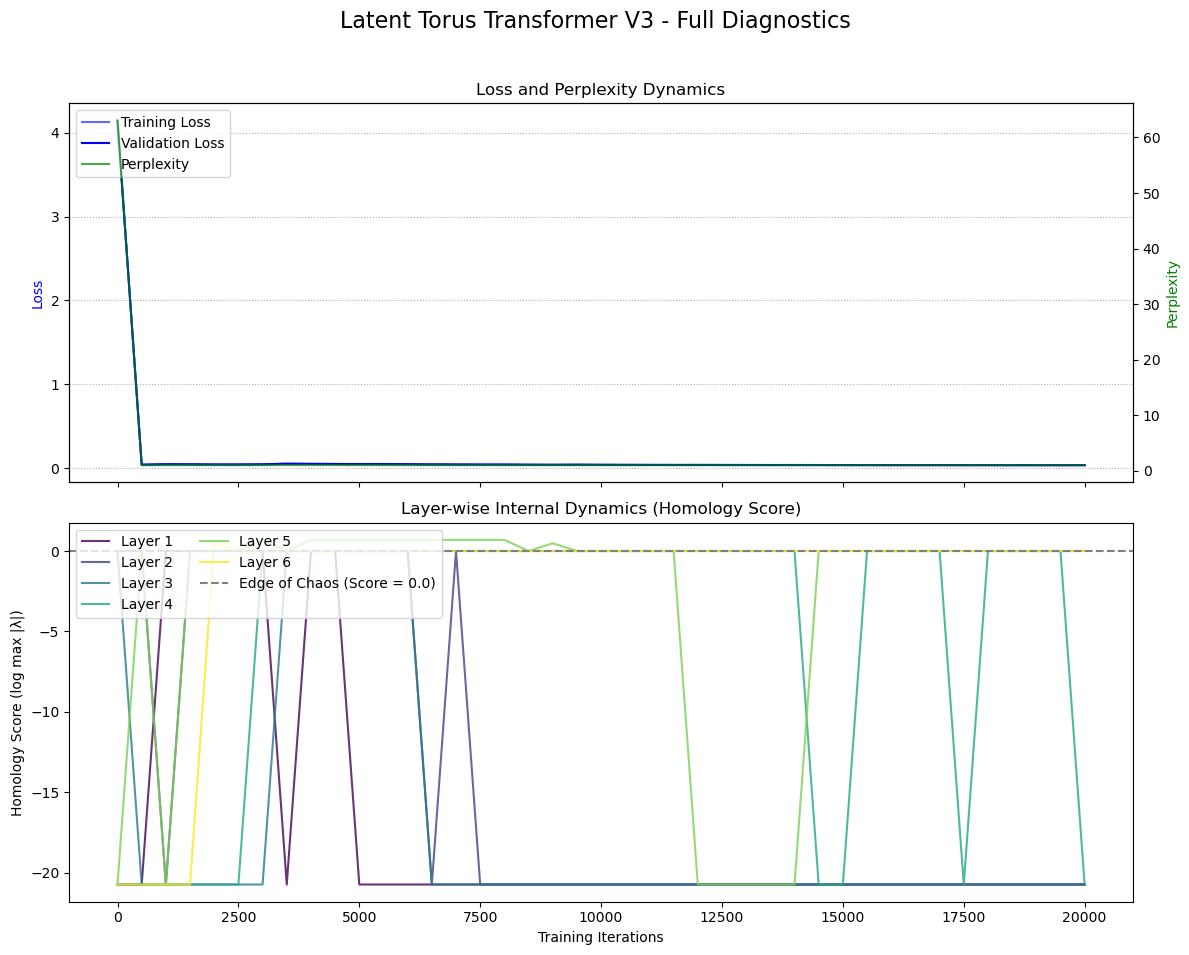

In [28]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import requests
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import warnings

# ===================================================================
# STEP 1: 데이터 및 하이퍼파라미터 (nanolm.ipynb에 맞춤)
# ===================================================================

# --- 하이퍼파라미터 ---
BATCH_SIZE = 128
BLOCK_SIZE = 64
MAX_ITERS = 20000 
EVAL_INTERVAL = 500
LEARNING_RATE = 5e-3 # nanoLM과 동일하게 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EVAL_ITERS = 200
N_EMBD = 256
N_HEAD = 8
N_LAYER = 6
DROPOUT = 0.2

# 코사인 학습률 스케줄러 (훈련 안정성을 위해 유지)
WARMUP_ITERS = 200
LR_DECAY_ITERS = 20000
MIN_LR = 5e-4 

# --- 데이터 준비 ---
def prepare_data(device):
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    text = requests.get(url).text
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
    data = torch.tensor(encode(text), dtype=torch.long)
    n = int(0.9 * len(data))
    train_data, val_data = data[:n], data[n:]
    return train_data, val_data, vocab_size, decode

def get_batch(split, train_data, val_data, block_size, batch_size, device):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# ===================================================================
# STEP 2: 모델 아키텍처 정의 (가중치 초기화 추가)
# ===================================================================

# --- 1. nanolm과 유사한 가중치 초기화 함수 ---
def _init_weights(module):
    if isinstance(module, (nn.Linear)):
        # Lecun/Xavier 초기화와 유사한 효과를 내는 표준 정규분포 초기화
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

# (이전과 동일한 모델 아키텍처 V3를 사용합니다)
class UnitCircleNormalization(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, z):
        z1, z2 = z[..., 0:2], z[..., 2:4]
        norm1 = torch.norm(z1, p=2, dim=-1, keepdim=True)
        norm2 = torch.norm(z2, p=2, dim=-1, keepdim=True)
        return torch.cat([z1 / (norm1 + self.epsilon), z2 / (norm2 + self.epsilon)], dim=-1)

class EncoderV3(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(d_model, d_model // 2), nn.GELU(), nn.Dropout(dropout), nn.Linear(d_model // 2, 4))
        self.normalizer = UnitCircleNormalization()
    def forward(self, x): return self.normalizer(self.net(x))

class LatentDynamicsDirect4D(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, 1024), nn.GELU(), nn.Dropout(dropout), nn.Linear(1024, 4))
        self.normalizer = UnitCircleNormalization()
        with torch.no_grad():
            self.net[-1].weight.data.zero_()
            for i in range(4): self.net[-1].weight.data[i, i] = 1.0
            self.net[-1].bias.data.zero_()
    def forward(self, z): return self.normalizer(self.net(z))

class DecoderV3(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, 4 * d_model), nn.GELU(), nn.Dropout(dropout), nn.Linear(4 * d_model, d_model))
    def forward(self, z): return self.net(z)

class LatentTorusTransformerBlockV3(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        self.ln1, self.ln2 = nn.LayerNorm(n_embd), nn.LayerNorm(n_embd)
        self.sa = nn.MultiheadAttention(n_embd, n_head, dropout=dropout, batch_first=True)
        self.encoder = EncoderV3(n_embd, dropout)
        self.latent_dynamics = LatentDynamicsDirect4D(dropout)
        self.decoder = DecoderV3(n_embd, dropout)
    def forward(self, x):
        x = x + self.sa(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        z = self.encoder(self.ln2(x))
        z_next = self.latent_dynamics(z)
        x = x + self.decoder(z_next)
        return x

class LatentTorusTransformerV3(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer, dropout):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[LatentTorusTransformerBlockV3(n_embd, n_head, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(_init_weights) # 모델 전체에 가중치 초기화 적용
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=DEVICE))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        logits = self.lm_head(self.ln_f(x))
        loss = F.cross_entropy(logits.view(B*T, -1), targets.view(B*T)) if targets is not None else None
        return logits, loss
    def generate(self, idx, max_new_tokens, block_size, temperature=0.8):
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        self.train()
        return idx

# ===================================================================
# STEP 3: Homology 분석 및 훈련 로직
# ===================================================================

def run_homological_analysis(dynamics_model, device, n_points=2000, tol=0.2):
    dynamics_model.eval()
    t = torch.linspace(0, 2*np.pi, n_points, device=device)
    loop1 = torch.stack([torch.cos(t), torch.sin(t), torch.ones_like(t), torch.zeros_like(t)], dim=1)
    loop2 = torch.stack([torch.ones_like(t), torch.zeros_like(t), torch.cos(t), torch.sin(t)], dim=1)
    transformed_loops_angle = []
    with torch.no_grad():
        for loop_trig in [loop1, loop2]:
            transformed_trig = dynamics_model(loop_trig)
            cos1, sin1, cos2, sin2 = transformed_trig.T
            theta_out, p_out = torch.atan2(sin1, cos1), torch.atan2(sin2, cos2)
            transformed_loops_angle.append(torch.stack([theta_out, p_out], dim=1).cpu().numpy())
    M = np.zeros((2, 2), dtype=int)
    for i, loop in enumerate(transformed_loops_angle):
        unwrapped = np.unwrap(loop, axis=0)
        raw_windings = (unwrapped[-1] - unwrapped[0]) / (2 * np.pi)
        approx_windings = np.round(raw_windings).astype(int)
        mask = ~np.isclose(raw_windings, approx_windings, atol=tol)
        if np.any(mask):
            warnings.warn(f"Winding deviation {raw_windings[mask]} exceeds tol={tol}, using nearest ints {approx_windings[mask]}", UserWarning)
        M[:, i] = approx_windings
    eigs = np.linalg.eigvals(M)
    score = np.log(np.max(np.abs(eigs)) + 1e-9)
    return M, score

@torch.no_grad()
def estimate_loss(model, train_data, val_data, block_size, batch_size, device, eval_iters):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, train_data, val_data, block_size, batch_size, device)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def get_lr(it):
    if it < WARMUP_ITERS: return LEARNING_RATE * it / WARMUP_ITERS
    if it > LR_DECAY_ITERS: return MIN_LR
    decay_ratio = (it - WARMUP_ITERS) / (LR_DECAY_ITERS - WARMUP_ITERS)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return MIN_LR + coeff * (LEARNING_RATE - MIN_LR)

# ===================================================================
# STEP 4: 메인 훈련 및 분석 함수
# ===================================================================

def train_and_monitor_model():
    print(f"--- Starting Experiment on {DEVICE} ---")
    train_data, val_data, vocab_size, decode = prepare_data(DEVICE)
    model = LatentTorusTransformerV3(vocab_size, N_EMBD, BLOCK_SIZE, N_HEAD, N_LAYER, DROPOUT).to(DEVICE)
    print(f"Total Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    log = []
    pbar = tqdm(range(MAX_ITERS))
    
    for it in pbar:
        lr = get_lr(it)
        for param_group in optimizer.param_groups: param_group['lr'] = lr
        xb, yb = get_batch('train', train_data, val_data, BLOCK_SIZE, BATCH_SIZE, DEVICE)
        _, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        # 그래디언트 클리핑 추가 (훈련 안정성 확보)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        if it % EVAL_INTERVAL == 0 or it == MAX_ITERS - 1:
            losses = estimate_loss(model, train_data, val_data, BLOCK_SIZE, BATCH_SIZE, DEVICE, EVAL_ITERS)
            val_loss = losses['val']
            perplexity = math.exp(val_loss) if val_loss < 20 else float('inf')
            
            # --- 2. 훈련 루프 수정: 레이어별 Homology 점수 기록 ---
            layer_homology_scores = {}
            for i in range(N_LAYER):
                dynamics_model = model.blocks[i].latent_dynamics
                _, score = run_homological_analysis(dynamics_model, DEVICE)
                layer_homology_scores[f'layer_{i}'] = score
            
            log_entry = {'iter': it, 'train_loss': losses['train'], 'val_loss': val_loss, 'perplexity': perplexity, 'lr': lr}
            log_entry.update({f'homology_layer_{i}': s for i, s in enumerate(layer_homology_scores.values())})
            log.append(log_entry)
            pbar.set_description(f"Iter {it}: Val Loss={val_loss:.4f}, PPL={perplexity:.2f}")

    df_log = pd.DataFrame(log)
    
    print("\n--- Final Text Generation ---")
    context = torch.zeros((1, 1), dtype=torch.long, device=DEVICE)
    generated_text = decode(model.generate(context, max_new_tokens=1000, block_size=BLOCK_SIZE)[0].tolist())
    print(generated_text)
    return df_log

# ===================================================================
# STEP 5: 종합 시각화 함수 (수정)
# ===================================================================

def plot_full_diagnostics(log_df):
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    fig.suptitle('Latent Torus Transformer V3 - Full Diagnostics', fontsize=16)

    # --- 상단 패널: 손실 및 복잡도 ---
    ax2 = ax1.twinx()
    ax1.plot(log_df['iter'], log_df['train_loss'], 'b-', alpha=0.6, label='Training Loss')
    ax1.plot(log_df['iter'], log_df['val_loss'], 'b-', alpha=1.0, label='Validation Loss')
    ax2.plot(log_df['iter'], log_df['perplexity'], 'g-', alpha=0.7, label='Perplexity')
    ax1.set_ylabel('Loss', color='b'); ax2.set_ylabel('Perplexity', color='g')
    ax1.set_title('Loss and Perplexity Dynamics'); ax1.grid(True, axis='y', linestyle=':')
    lines1, labels1 = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # --- 3. 시각화 함수 수정: 레이어별 동역학 플롯 ---
    ax3.set_title('Layer-wise Internal Dynamics (Homology Score)')
    ax3.set_xlabel('Training Iterations'); ax3.set_ylabel('Homology Score (log max |λ|)')
    colors = plt.cm.viridis(np.linspace(0, 1, N_LAYER))
    for i in range(N_LAYER):
        ax3.plot(log_df['iter'], log_df[f'homology_layer_{i}'], color=colors[i], label=f'Layer {i+1}', alpha=0.8)
    ax3.axhline(y=0.0, color='grey', linestyle='--', label='Edge of Chaos (Score = 0.0)')
    ax3.legend(loc='upper left', ncol=2)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.96]); plt.savefig("v3_full_diagnostics.pdf"); plt.show()

# ===================================================================
# STEP 6: 메인 실행부
# ===================================================================

if __name__ == '__main__':
    log_df = train_and_monitor_model()
    if not log_df.empty:
        plot_full_diagnostics(log_df)

--- Starting Experiment on cuda ---
Total Parameters: 3.50M


Iter 49999: Val Loss=0.0336, PPL=1.03: 100%|██████████| 50000/50000 [40:57<00:00, 20.35it/s]  



--- Final Text Generation ---
































































VOLIO:
And!

CARD I wheen,
He to thou to best fer.

Sa ther
Mere me pariow thime, if and the than:
Now of ougken ond thour sord prof blondemt as whis hemean thout wich are tade the gut: I lew
 shergrow than praby to pend of he mee:
Thad gand ine fued, and of this dichure of of by mared.

SOUT:
Thand diad magncowike ant at und tor areaw our as our thaw wher alm'd her him and his her motlond nosthe noving thes of chy you gron his frorobe chan erer ware or stobe: sance
Thas fee,
Ther the chest.

BUTHARD ICINGHARDORD:
I we serord I if move ou bad fing hor coud Yout
Serthy his to be mather hask thou one:
O che the butore
No ther rof.

PORIUS:
Puthd yourg you he vaves fory,
Thou the
De with tom mou spacer of thou doumentey moup loup and and ur forst. You, so hime
To fooorerg mare nees bromessest ald whery, thoutince.

Have cor,
Bre.

CARG:
Tee, wind my mamy sull by you sull omt:
The bend, oust.

ME

C:\Users\master\AppData\Local\Temp\ipykernel_33896\139759438.py:268: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax_loss.plot(log_df.index, log_df['val_loss'].dropna(), 'b-', alpha=1.0, marker='o', markersize=4, linestyle='--', label='Validation Loss')


ValueError: x and y must have same first dimension, but have shapes (501,) and (51,)

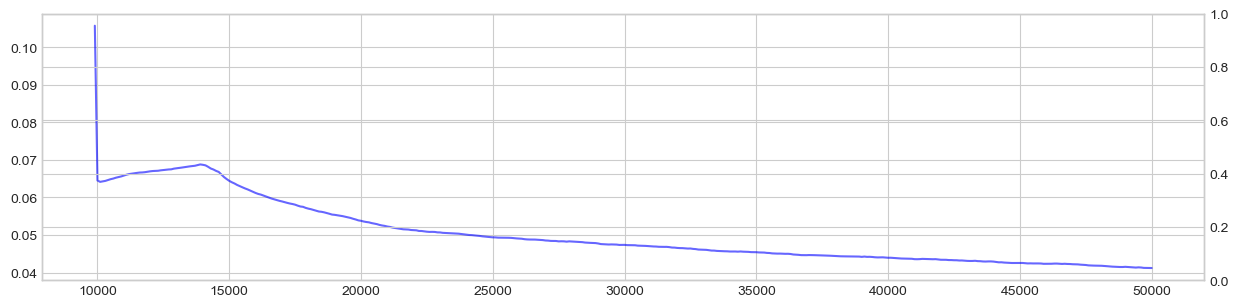

In [29]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm
import numpy as np
import warnings

# ===================================================================
# STEP 1: 데이터 및 하이퍼파라미터 (nanolm.ipynb에 맞춤)
# ===================================================================
BATCH_SIZE = 128
BLOCK_SIZE = 64
MAX_ITERS = 50000
EVAL_INTERVAL = 1000 # 평가 주기를 조금 늘려, Homology 계산과 겹치지 않게 함
HOMOLOGY_INTERVAL = 100 # Homology 계산을 더 자주 수행
LEARNING_RATE = 5e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EVAL_ITERS = 200
N_EMBD = 256
N_HEAD = 8
N_LAYER = 6
DROPOUT = 0.2
WARMUP_ITERS = 200
LR_DECAY_ITERS = 20000
MIN_LR = 5e-4

# --- 데이터 준비 ---
def prepare_data(device):
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    text = requests.get(url).text
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
    data = torch.tensor(encode(text), dtype=torch.long)
    n = int(0.9 * len(data))
    train_data, val_data = data[:n], data[n:]
    return train_data, val_data, vocab_size, decode

def get_batch(split, train_data, val_data, block_size, batch_size, device):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# ===================================================================
# STEP 2: 모델 아키텍처 정의 (가중치 초기화 추가)
# ===================================================================

# --- 1. nanolm과 유사한 가중치 초기화 함수 ---
def _init_weights(module):
    if isinstance(module, (nn.Linear)):
        # Lecun/Xavier 초기화와 유사한 효과를 내는 표준 정규분포 초기화
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

# (이전과 동일한 모델 아키텍처 V3를 사용합니다)
class UnitCircleNormalization(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, z):
        z1, z2 = z[..., 0:2], z[..., 2:4]
        norm1 = torch.norm(z1, p=2, dim=-1, keepdim=True)
        norm2 = torch.norm(z2, p=2, dim=-1, keepdim=True)
        return torch.cat([z1 / (norm1 + self.epsilon), z2 / (norm2 + self.epsilon)], dim=-1)

class EncoderV3(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(d_model, d_model // 2), nn.GELU(), nn.Dropout(dropout), nn.Linear(d_model // 2, 4))
        self.normalizer = UnitCircleNormalization()
    def forward(self, x): return self.normalizer(self.net(x))

class LatentDynamicsDirect4D(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, 1024), nn.GELU(), nn.Dropout(dropout), nn.Linear(1024, 4))
        self.normalizer = UnitCircleNormalization()
        with torch.no_grad():
            self.net[-1].weight.data.zero_()
            for i in range(4): self.net[-1].weight.data[i, i] = 1.0
            self.net[-1].bias.data.zero_()
    def forward(self, z): return self.normalizer(self.net(z))

class DecoderV3(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, 4 * d_model), nn.GELU(), nn.Dropout(dropout), nn.Linear(4 * d_model, d_model))
    def forward(self, z): return self.net(z)

class LatentTorusTransformerBlockV3(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        self.ln1, self.ln2 = nn.LayerNorm(n_embd), nn.LayerNorm(n_embd)
        self.sa = nn.MultiheadAttention(n_embd, n_head, dropout=dropout, batch_first=True)
        self.encoder = EncoderV3(n_embd, dropout)
        self.latent_dynamics = LatentDynamicsDirect4D(dropout)
        self.decoder = DecoderV3(n_embd, dropout)
    def forward(self, x):
        x = x + self.sa(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        z = self.encoder(self.ln2(x))
        z_next = self.latent_dynamics(z)
        x = x + self.decoder(z_next)
        return x

class LatentTorusTransformerV3(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer, dropout):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[LatentTorusTransformerBlockV3(n_embd, n_head, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(_init_weights) # 모델 전체에 가중치 초기화 적용
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=DEVICE))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        logits = self.lm_head(self.ln_f(x))
        loss = F.cross_entropy(logits.view(B*T, -1), targets.view(B*T)) if targets is not None else None
        return logits, loss
    def generate(self, idx, max_new_tokens, block_size, temperature=0.8):
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        self.train()
        return idx

# ===================================================================
# STEP 3: Homology 분석 및 훈련 로직
# ===================================================================

def run_homological_analysis(dynamics_model, device, n_points=2000, tol=0.2):
    dynamics_model.eval()
    t = torch.linspace(0, 2*np.pi, n_points, device=device)
    loop1 = torch.stack([torch.cos(t), torch.sin(t), torch.ones_like(t), torch.zeros_like(t)], dim=1)
    loop2 = torch.stack([torch.ones_like(t), torch.zeros_like(t), torch.cos(t), torch.sin(t)], dim=1)
    transformed_loops_angle = []
    with torch.no_grad():
        for loop_trig in [loop1, loop2]:
            transformed_trig = dynamics_model(loop_trig)
            cos1, sin1, cos2, sin2 = transformed_trig.T
            theta_out, p_out = torch.atan2(sin1, cos1), torch.atan2(sin2, cos2)
            transformed_loops_angle.append(torch.stack([theta_out, p_out], dim=1).cpu().numpy())
    M = np.zeros((2, 2), dtype=int)
    for i, loop in enumerate(transformed_loops_angle):
        unwrapped = np.unwrap(loop, axis=0)
        raw_windings = (unwrapped[-1] - unwrapped[0]) / (2 * np.pi)
        approx_windings = np.round(raw_windings).astype(int)
        mask = ~np.isclose(raw_windings, approx_windings, atol=tol)
        if np.any(mask):
            warnings.warn(f"Winding deviation {raw_windings[mask]} exceeds tol={tol}, using nearest ints {approx_windings[mask]}", UserWarning)
        M[:, i] = approx_windings
    eigs = np.linalg.eigvals(M)
    score = np.log(np.max(np.abs(eigs)) + 1e-9)
    return M, score

@torch.no_grad()
def estimate_loss(model, train_data, val_data, block_size, batch_size, device, eval_iters):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, train_data, val_data, block_size, batch_size, device)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def get_lr(it):
    if it < WARMUP_ITERS: return LEARNING_RATE * it / WARMUP_ITERS
    if it > LR_DECAY_ITERS: return MIN_LR
    decay_ratio = (it - WARMUP_ITERS) / (LR_DECAY_ITERS - WARMUP_ITERS)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return MIN_LR + coeff * (LEARNING_RATE - MIN_LR)

# ===================================================================
# STEP 4: 메인 훈련 및 분석 함수
# ===================================================================

def train_and_monitor_model():
    print(f"--- Starting Experiment on {DEVICE} ---")
    train_data, val_data, vocab_size, decode = prepare_data(DEVICE)
    model = LatentTorusTransformerV3(vocab_size, N_EMBD, BLOCK_SIZE, N_HEAD, N_LAYER, DROPOUT).to(DEVICE)
    print(f"Total Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    log = []
    pbar = tqdm(range(MAX_ITERS))
    
    for it in pbar:
        # 훈련 스텝
        lr = get_lr(it)
        for param_group in optimizer.param_groups: param_group['lr'] = lr
        xb, yb = get_batch('train', train_data, val_data, BLOCK_SIZE, BATCH_SIZE, DEVICE)
        _, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # 로깅
        log_entry = {'iter': it, 'lr': lr, 'train_loss': loss.item()}
        
        # Homology 분석 (더 자주 수행)
        if it % HOMOLOGY_INTERVAL == 0 or it == MAX_ITERS - 1:
            for i in range(N_LAYER):
                dynamics_model = model.blocks[i].latent_dynamics
                _, score = run_homological_analysis(dynamics_model, DEVICE)
                log_entry[f'homology_layer_{i}'] = score
        
        # 평가 (가끔 수행)
        if it % EVAL_INTERVAL == 0 or it == MAX_ITERS - 1:
            losses = estimate_loss(model, train_data, val_data, BLOCK_SIZE, BATCH_SIZE, DEVICE, EVAL_ITERS)
            log_entry['val_loss'] = losses['val']
            log_entry['perplexity'] = math.exp(losses['val']) if losses['val'] < 20 else float('inf')
            pbar.set_description(f"Iter {it}: Val Loss={losses['val']:.4f}, PPL={math.exp(losses['val']):.2f}")
        
        log.append(log_entry)

    # 데이터프레임 생성 시, 모든 반복에서 기록되지 않은 값은 NaN으로 채워짐
    df_log = pd.DataFrame(log).set_index('iter')
    
    print("\n--- Final Text Generation ---")
    context = torch.zeros((1, 1), dtype=torch.long, device=DEVICE)
    generated_text = decode(model.generate(context, max_new_tokens=1000, block_size=BLOCK_SIZE)[0].tolist())
    print(generated_text)
    
    return df_log

# ===================================================================
# STEP 5: 종합 시각화 함수 (레이어별 subplot으로 수정)
# ===================================================================

def plot_full_diagnostics(log_df):
    plt.style.use('seaborn-v0_8-whitegrid')
    # Figure와 GridSpec을 사용하여 레이아웃 정의
    fig = plt.figure(figsize=(15, 18))
    gs = gridspec.GridSpec(4, 2, figure=fig, hspace=0.4, wspace=0.2)

    # --- 상단 패널: 손실 및 복잡도 ---
    ax_loss = fig.add_subplot(gs[0, :]) # 첫 번째 행을 모두 사용
    ax_perp = ax_loss.twinx()
    
    # train_loss는 더 부드럽게 보이기 위해 rolling average 사용
    ax_loss.plot(log_df.index, log_df['train_loss'].dropna().rolling(window=HOMOLOGY_INTERVAL).mean(), 'b-', alpha=0.6, label='Training Loss (smoothed)')
    ax_loss.plot(log_df.index, log_df['val_loss'].dropna(), 'b-', alpha=1.0, marker='o', markersize=4, linestyle='--', label='Validation Loss')
    ax_perp.plot(log_df.index, log_df['perplexity'].dropna(), 'g-', alpha=0.8, label='Perplexity')
    
    ax_loss.set_title('Loss and Perplexity Dynamics', fontsize=14)
    ax_loss.set_ylabel('Loss', color='b'); ax_perp.set_ylabel('Perplexity', color='g')
    ax_loss.set_ylim(bottom=0) # Loss는 0 이하로 내려가지 않음

    lines1, labels1 = ax_loss.get_legend_handles_labels()
    lines2, labels2 = ax_perp.get_legend_handles_labels()
    ax_loss.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    # --- 하단 3x2 그리드: 레이어별 Homology 점수 ---
    fig.suptitle('Latent Torus Transformer V3 - Full Diagnostics', fontsize=20, y=0.99)
    
    for i in range(N_LAYER):
        row = 1 + (i // 2)
        col = i % 2
        ax = fig.add_subplot(gs[row, col])
        
        # Homology score를 부드럽게 표시
        ax.plot(log_df.index, log_df[f'homology_layer_{i}'].dropna(), color='r', alpha=0.6, linewidth=1.5)
        ax.axhline(y=0.0, color='grey', linestyle='--', label='Edge of Chaos (Score = 0.0)')
        
        ax.set_title(f'Layer {i+1} Dynamics', fontsize=12)
        if row == 3: # 마지막 행에만 xlabel 표시
            ax.set_xlabel('Training Iterations')
        if col == 0: # 첫 번째 열에만 ylabel 표시
            ax.set_ylabel('Homology Score')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig("v3_full_diagnostics_revised.pdf")
    plt.show()


# ===================================================================
# STEP 6: 메인 실행부
# ===================================================================

if __name__ == '__main__':
    # 데이터 준비 함수는 여기에 한 번만 호출
    train_data, val_data, vocab_size, decode = prepare_data(DEVICE)

    # train_and_monitor_model 함수가 이 데이터를 받도록 수정
    def train_and_monitor_model_main(train_data, val_data, vocab_size, decode):
        print(f"--- Starting Experiment on {DEVICE} ---")
        model = LatentTorusTransformerV3(vocab_size, N_EMBD, BLOCK_SIZE, N_HEAD, N_LAYER, DROPOUT).to(DEVICE)
        print(f"Total Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
        log = []
        pbar = tqdm(range(MAX_ITERS))
        
        for it in pbar:
            lr = get_lr(it)
            for param_group in optimizer.param_groups: param_group['lr'] = lr
            xb, yb = get_batch('train', train_data, val_data, BLOCK_SIZE, BATCH_SIZE, DEVICE)
            _, loss = model(xb, yb)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            log_entry = {'iter': it, 'lr': lr, 'train_loss': loss.item()}
            
            if it % HOMOLOGY_INTERVAL == 0 or it == MAX_ITERS - 1:
                for i in range(N_LAYER):
                    dynamics_model = model.blocks[i].latent_dynamics
                    _, score = run_homological_analysis(dynamics_model, DEVICE)
                    log_entry[f'homology_layer_{i}'] = score
            
            if it % EVAL_INTERVAL == 0 or it == MAX_ITERS - 1:
                losses = estimate_loss(model, train_data, val_data, BLOCK_SIZE, BATCH_SIZE, DEVICE, EVAL_ITERS)
                log_entry['val_loss'] = losses['val']
                log_entry['perplexity'] = math.exp(losses['val']) if losses['val'] < 20 else float('inf')
                pbar.set_description(f"Iter {it}: Val Loss={losses['val']:.4f}, PPL={math.exp(losses['val']):.2f}")
            
            if log_entry.get('val_loss') is not None or log_entry.get('homology_layer_0') is not None:
                log.append(log_entry)

        df_log = pd.DataFrame(log).set_index('iter')
        
        print("\n--- Final Text Generation ---")
        context = torch.zeros((1, 1), dtype=torch.long, device=DEVICE)
        generated_text = decode(model.generate(context, max_new_tokens=1000, block_size=BLOCK_SIZE)[0].tolist())
        print(generated_text)
        
        return df_log
    
    # 수정된 메인 함수 호출
    log_df = train_and_monitor_model_main(train_data, val_data, vocab_size, decode)
    if not log_df.empty:
        plot_full_diagnostics(log_df)

C:\Users\master\AppData\Local\Temp\ipykernel_33896\2551812652.py:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax_loss.plot(val_data.index, val_data, 'b-', alpha=1.0, marker='o', markersize=4, linestyle='--', label='Validation Loss')
C:\Users\master\AppData\Local\Temp\ipykernel_33896\2551812652.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


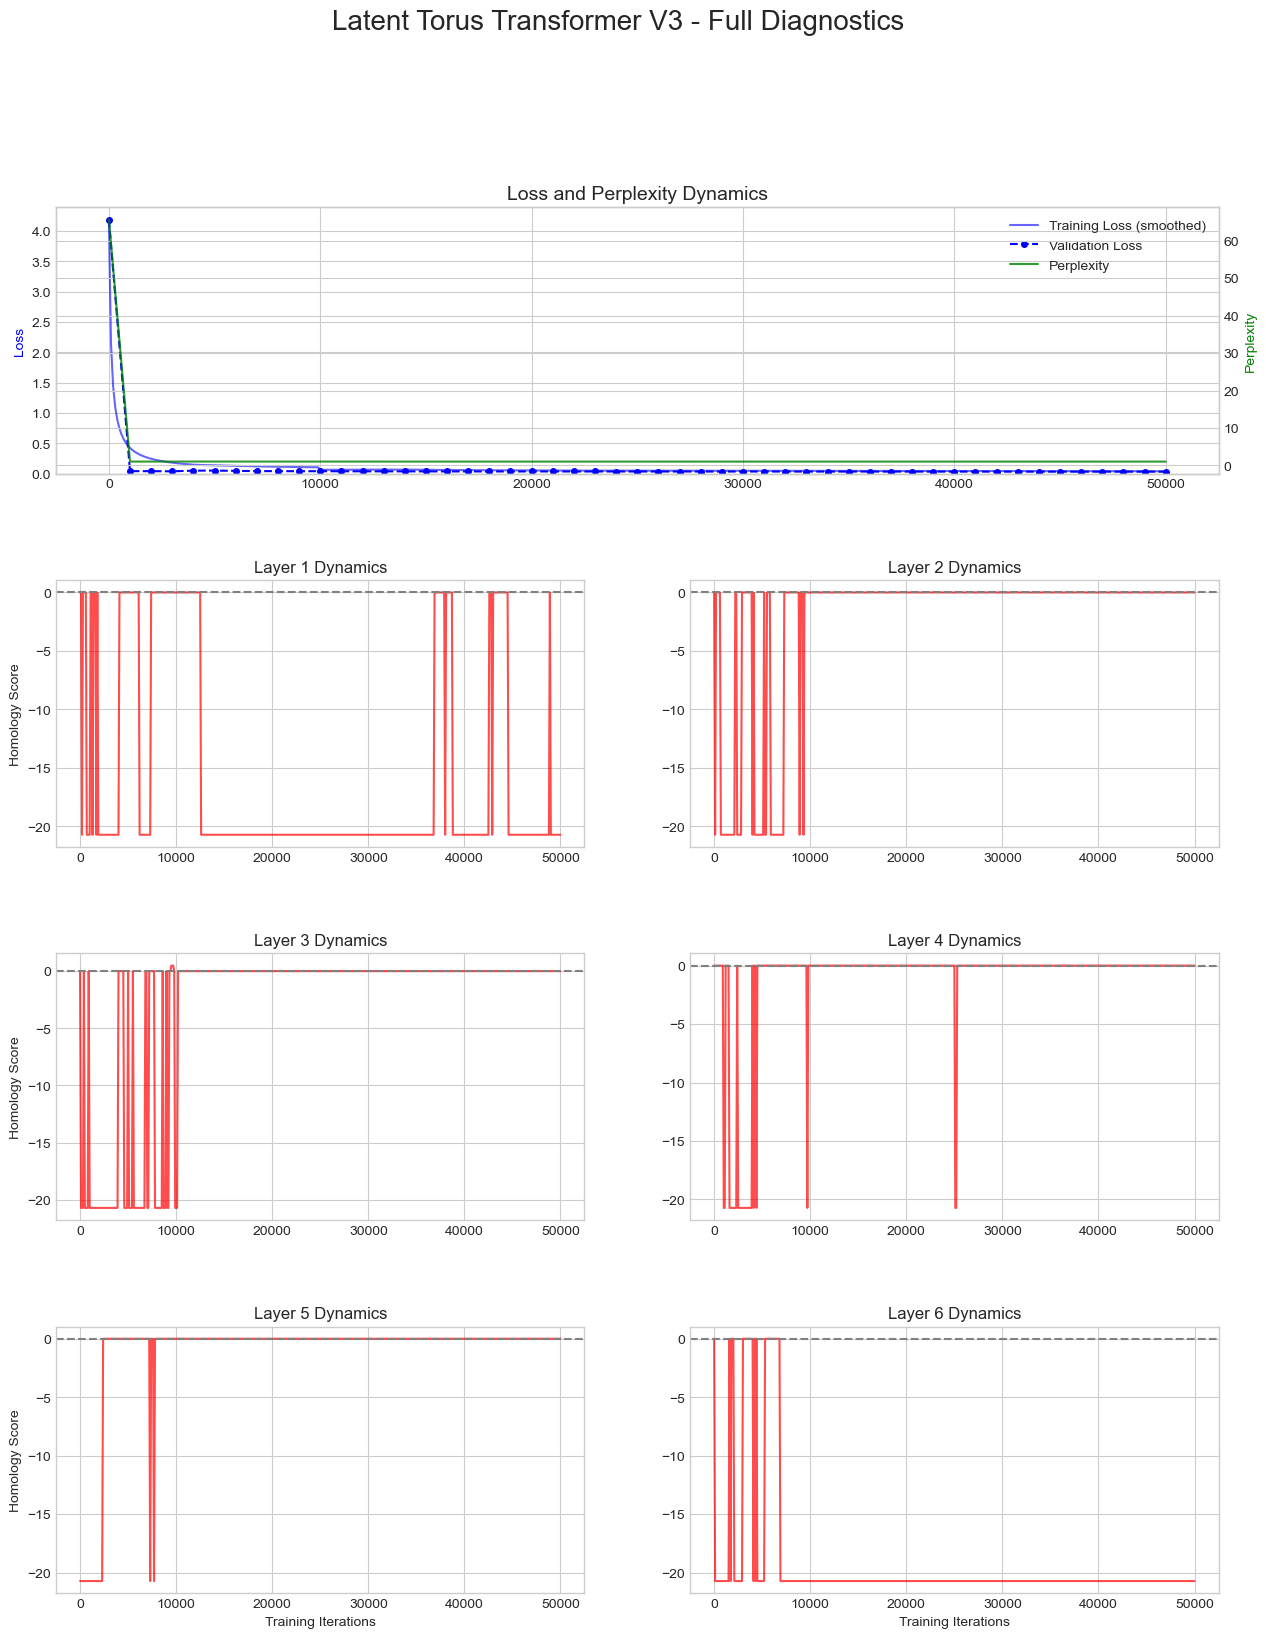

In [30]:
def plot_full_diagnostics(log_df):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(15, 18))
    gs = gridspec.GridSpec(4, 2, figure=fig, hspace=0.4, wspace=0.2)

    # --- 상단 패널: 손실 및 복잡도 ---
    ax_loss = fig.add_subplot(gs[0, :])
    ax_perp = ax_loss.twinx()

    # train_loss는 더 부드럽게 보이기 위해 rolling average 사용
    ax_loss.plot(log_df.index, log_df['train_loss'].dropna().rolling(window=HOMOLOGY_INTERVAL, min_periods=1).mean(), 'b-', alpha=0.6, label='Training Loss (smoothed)')
    
    # --- 🔥 에러 수정 부분 시작 ---
    # val_loss가 NaN이 아닌 행들만 선택하여 x와 y를 함께 필터링
    val_data = log_df['val_loss'].dropna()
    ax_loss.plot(val_data.index, val_data, 'b-', alpha=1.0, marker='o', markersize=4, linestyle='--', label='Validation Loss')
    
    perp_data = log_df['perplexity'].dropna()
    ax_perp.plot(perp_data.index, perp_data, 'g-', alpha=0.8, label='Perplexity')
    # --- 🔥 에러 수정 부분 끝 ---
    
    ax_loss.set_title('Loss and Perplexity Dynamics', fontsize=14)
    ax_loss.set_ylabel('Loss', color='b')
    ax_perp.set_ylabel('Perplexity', color='g')
    ax_loss.set_ylim(bottom=0)

    lines1, labels1 = ax_loss.get_legend_handles_labels()
    lines2, labels2 = ax_perp.get_legend_handles_labels()
    ax_loss.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    # --- 하단 3x2 그리드: 레이어별 Homology 점수 ---
    fig.suptitle('Latent Torus Transformer V3 - Full Diagnostics', fontsize=20, y=0.99)
    
    for i in range(N_LAYER):
        row = 1 + (i // 2)
        col = i % 2
        ax = fig.add_subplot(gs[row, col], sharex=ax_loss) # x축 공유
        
        # Homology score가 NaN이 아닌 데이터만 필터링하여 플롯
        homology_data = log_df[f'homology_layer_{i}'].dropna()
        ax.plot(homology_data.index, homology_data, color='r', alpha=0.7, linewidth=1.5)
        ax.axhline(y=0.0, color='grey', linestyle='--', label='Edge of Chaos (Score = 0.0)')
        
        ax.set_title(f'Layer {i+1} Dynamics', fontsize=12)
        if row == 3:
            ax.set_xlabel('Training Iterations')
        if col == 0:
            ax.set_ylabel('Homology Score')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig("v3_full_diagnostics_revised.pdf")
    plt.show()
    
plot_full_diagnostics(log_df)

In [31]:
log_df

,lr,train_loss,homology_layer_0,homology_layer_1,homology_layer_2,homology_layer_3,homology_layer_4,homology_layer_5,val_loss,perplexity
iter,,,,,,,,,,
0,0.000000,4.180948,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,-2.072327e+01,1.000000e-09,tensor(4.1851),65.702237
100,0.002500,0.106651,1.000000e-09,-2.072327e+01,-2.072327e+01,1.000000e-09,-2.072327e+01,-2.072327e+01,NaN,NaN
200,0.005000,0.049703,-2.072327e+01,1.000000e-09,-2.072327e+01,1.000000e-09,-2.072327e+01,-2.072327e+01,NaN,NaN
300,0.005000,0.045735,1.000000e-09,1.000000e-09,-2.072327e+01,1.000000e-09,-2.072327e+01,-2.072327e+01,NaN,NaN
400,0.004999,0.044392,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,-2.072327e+01,-2.072327e+01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
49600,0.000500,0.039877,-2.072327e+01,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,-2.072327e+01,NaN,NaN
49700,0.000500,0.035567,-2.072327e+01,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,-2.072327e+01,NaN,NaN
49800,0.000500,0.041271,-2.072327e+01,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,-2.072327e+01,NaN,NaN


In [32]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm
import numpy as np
import warnings
import os

# ===================================================================
# STEP 1: 실험 환경 설정
# ===================================================================

# --- 하이퍼파라미터 ---
BATCH_SIZE = 128
BLOCK_SIZE = 64
MAX_ITERS = 50000 # 최종 실험이므로 충분히 길게 설정
EVAL_INTERVAL = 1000
HOMOLOGY_INTERVAL = 100
LEARNING_RATE = 5e-4 # 안정성이 검증된 값으로 고정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EVAL_ITERS = 200
N_EMBD = 256
N_HEAD = 8
N_LAYER = 6
DROPOUT = 0.2
WARMUP_ITERS = 2000 # 전체 훈련 기간에 맞춰 조정
LR_DECAY_ITERS = 50000
MIN_LR = 5e-5

# --- 실험 그룹 및 시드 정의 ---
SEEDS = [42, 123, 2024]
EXPERIMENTS = {
    "Control (EoC)": {
        "use_regularizer": False,
        "lambda_reg": 0.0,
        "target_score": 0.0
    },
    "Forced Chaos": {
        "use_regularizer": True,
        "lambda_reg": 0.01,
        "target_score": 0.5
    },
    "Forced Stability": {
        "use_regularizer": True,
        "lambda_reg": 0.01,
        "target_score": -5.0
    }
}

# (데이터 준비, 모델 아키텍처, 분석 함수 등은 이전과 동일)
# ... 이전 답변의 STEP 1 후반부 ~ STEP 3 전체 코드가 여기에 위치 ...
# ===================================================================
# STEP 2 & 3: 모델, 분석, 훈련 로직 (이전과 동일)
# ===================================================================
def prepare_data(device):
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    text = requests.get(url).text
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
    data = torch.tensor(encode(text), dtype=torch.long)
    n = int(0.9 * len(data))
    train_data, val_data = data[:n], data[n:]
    return train_data, val_data, vocab_size, decode

def get_batch(split, train_data, val_data, block_size, batch_size, device):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y
    
def _init_weights(module):
    if isinstance(module, (nn.Linear)):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None: torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

class UnitCircleNormalization(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, z):
        z1, z2 = z[..., 0:2], z[..., 2:4]
        norm1 = torch.norm(z1, p=2, dim=-1, keepdim=True)
        norm2 = torch.norm(z2, p=2, dim=-1, keepdim=True)
        return torch.cat([z1 / (norm1 + self.epsilon), z2 / (norm2 + self.epsilon)], dim=-1)

class EncoderV3(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(d_model, d_model // 2), nn.GELU(), nn.Dropout(dropout), nn.Linear(d_model // 2, 4))
        self.normalizer = UnitCircleNormalization()
    def forward(self, x): return self.normalizer(self.net(x))

class LatentDynamicsDirect4D(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, 1024), nn.GELU(), nn.Dropout(dropout), nn.Linear(1024, 4))
        self.normalizer = UnitCircleNormalization()
        with torch.no_grad():
            self.net[-1].weight.data.zero_()
            for i in range(4): self.net[-1].weight.data[i, i] = 1.0
            self.net[-1].bias.data.zero_()
    def forward(self, z): return self.normalizer(self.net(z))

class DecoderV3(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, 4 * d_model), nn.GELU(), nn.Dropout(dropout), nn.Linear(4 * d_model, d_model))
    def forward(self, z): return self.net(z)

class LatentTorusTransformerBlockV3(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        self.ln1, self.ln2 = nn.LayerNorm(n_embd), nn.LayerNorm(n_embd)
        self.sa = nn.MultiheadAttention(n_embd, n_head, dropout=dropout, batch_first=True)
        self.encoder = EncoderV3(n_embd, dropout)
        self.latent_dynamics = LatentDynamicsDirect4D(dropout)
        self.decoder = DecoderV3(n_embd, dropout)
    def forward(self, x):
        x = x + self.sa(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        z = self.encoder(self.ln2(x))
        z_next = self.latent_dynamics(z)
        x = x + self.decoder(z_next)
        return x

class LatentTorusTransformerV3(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer, dropout):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[LatentTorusTransformerBlockV3(n_embd, n_head, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(_init_weights)
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=DEVICE))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        logits = self.lm_head(self.ln_f(x))
        loss = F.cross_entropy(logits.view(B*T, -1), targets.view(B*T)) if targets is not None else None
        return logits, loss
    def generate(self, idx, max_new_tokens, block_size, temperature=0.8):
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        self.train()
        return idx

def run_homological_analysis(dynamics_model, device, n_points=200, tol=0.2):
    dynamics_model.eval()
    t = torch.linspace(0, 2*np.pi, n_points, device=device)
    loop1 = torch.stack([torch.cos(t), torch.sin(t), torch.ones_like(t), torch.zeros_like(t)], dim=1)
    loop2 = torch.stack([torch.ones_like(t), torch.zeros_like(t), torch.cos(t), torch.sin(t)], dim=1)
    transformed_loops_angle = []
    with torch.no_grad():
        for loop_trig in [loop1, loop2]:
            transformed_trig = dynamics_model(loop_trig)
            cos1, sin1, cos2, sin2 = transformed_trig.T
            theta_out, p_out = torch.atan2(sin1, cos1), torch.atan2(sin2, cos2)
            transformed_loops_angle.append(torch.stack([theta_out, p_out], dim=1).cpu().numpy())
    M = np.zeros((2, 2), dtype=int)
    for i, loop in enumerate(transformed_loops_angle):
        unwrapped = np.unwrap(loop, axis=0)
        raw_windings = (unwrapped[-1] - unwrapped[0]) / (2 * np.pi)
        approx_windings = np.round(raw_windings).astype(int)
        mask = ~np.isclose(raw_windings, approx_windings, atol=tol)
        if np.any(mask):
            warnings.warn(f"Winding deviation {raw_windings[mask]} exceeds tol={tol}, using nearest ints {approx_windings[mask]}", UserWarning)
        M[:, i] = approx_windings
    eigs = np.linalg.eigvals(M)
    score = np.log(np.max(np.abs(eigs)) + 1e-9)
    return M, score

def compute_jacobian_proxy_score(dynamics_model, device, n_samples=10):
    random_angles = torch.rand(n_samples, 2, device=device) * 2 * math.pi
    cos_vals, sin_vals = torch.cos(random_angles), torch.sin(random_angles)
    z = torch.cat([cos_vals[:,0:1], sin_vals[:,0:1], cos_vals[:,1:2], sin_vals[:,1:2]], dim=1)
    compute_jacobian = torch.func.jacrev(dynamics_model)
    jacobians = torch.vmap(compute_jacobian)(z)
    singular_values = torch.linalg.svdvals(jacobians)
    max_singular_values = singular_values[:, 0]
    proxy_score = torch.log(max_singular_values + 1e-9)
    return proxy_score.mean()

@torch.no_grad()
def estimate_loss(model, train_data, val_data, block_size, batch_size, device, eval_iters):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, train_data, val_data, block_size, batch_size, device)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def get_lr(it):
    if it < WARMUP_ITERS: return LEARNING_RATE * it / WARMUP_ITERS
    if it > LR_DECAY_ITERS: return MIN_LR
    decay_ratio = (it - WARMUP_ITERS) / (LR_DECAY_ITERS - WARMUP_ITERS)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return MIN_LR + coeff * (LEARNING_RATE - MIN_LR)

# ===================================================================
# STEP 4: 모듈화된 단일 실험 실행 함수
# ===================================================================

def run_single_experiment(config, train_data, val_data, vocab_size, decode):
    run_name = config['run_name']
    seed = config['seed']
    print(f"--- Starting Run: {run_name} (Seed: {seed}) ---")

    # 재현성을 위한 시드 설정
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = LatentTorusTransformerV3(vocab_size, N_EMBD, BLOCK_SIZE, N_HEAD, N_LAYER, DROPOUT).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    log = []
    pbar = tqdm(range(MAX_ITERS), desc=f"{run_name} Seed {seed}")
    
    for it in pbar:
        lr = get_lr(it)
        for param_group in optimizer.param_groups: param_group['lr'] = lr
        xb, yb = get_batch('train', train_data, val_data, BLOCK_SIZE, BATCH_SIZE, DEVICE)
        _, loss = model(xb, yb)
        
        # --- 위상적 정규화 적용 ---
        if config['use_regularizer']:
            avg_proxy_score = 0
            for i in range(N_LAYER):
                dynamics_model = model.blocks[i].latent_dynamics
                avg_proxy_score += compute_jacobian_proxy_score(dynamics_model, DEVICE)
            avg_proxy_score /= N_LAYER
            reg_loss = config['lambda_reg'] * (avg_proxy_score - config['target_score'])**2
            loss = loss + reg_loss
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # --- 로깅 ---
        log_entry = {'iter': it, 'train_loss': loss.item()}
        if it % HOMOLOGY_INTERVAL == 0 or it == MAX_ITERS - 1:
            avg_homology_score = 0
            for i in range(N_LAYER):
                dynamics_model = model.blocks[i].latent_dynamics
                _, score = run_homological_analysis(dynamics_model, DEVICE)
                log_entry[f'homology_layer_{i}'] = score
                avg_homology_score += score
            log_entry['avg_homology_score'] = avg_homology_score / N_LAYER
        
        if it % EVAL_INTERVAL == 0 or it == MAX_ITERS - 1:
            losses = estimate_loss(model, train_data, val_data, BLOCK_SIZE, BATCH_SIZE, DEVICE, EVAL_ITERS)
            log_entry['val_loss'] = losses['val']
            log_entry['perplexity'] = math.exp(losses['val']) if losses['val'] < 20 else float('inf')
            pbar.set_description(f"{run_name} Seed {seed} | Val Loss: {losses['val']:.4f}")
        
        if log_entry.get('val_loss') is not None or log_entry.get('homology_layer_0') is not None:
            log.append(log_entry)

    df_log = pd.DataFrame(log).set_index('iter')
    
    # --- 결과 저장 ---
    log_dir = "logs"
    os.makedirs(log_dir, exist_ok=True)
    df_log.to_csv(os.path.join(log_dir, f"{run_name}_seed_{seed}.csv"))

    print(f"--- Finished Run: {run_name} (Seed: {seed}) ---")
    # 마지막 모델의 텍스트 생성 샘플 저장
    context = torch.zeros((1, 1), dtype=torch.long, device=DEVICE)
    generated_text = decode(model.generate(context, max_new_tokens=500, block_size=BLOCK_SIZE)[0].tolist())
    with open(os.path.join(log_dir, f"generated_text_{run_name}_seed_{seed}.txt"), "w", encoding='utf-8') as f:
        f.write(generated_text)

# ===================================================================
# STEP 5: 종합 결과 분석 및 시각화 함수
# ===================================================================

def analyze_all_results(experiments, seeds):
    print("\n--- Analyzing all experiment results ---")
    log_dir = "logs"
    all_dfs = []
    for exp_name in experiments:
        for seed in seeds:
            file_path = os.path.join(log_dir, f"{exp_name.replace(' ', '_')}_seed_{seed}.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                df['experiment'] = exp_name
                df['seed'] = seed
                all_dfs.append(df)
    
    if not all_dfs:
        print("No log files found. Please run the experiments first.")
        return

    full_df = pd.concat(all_dfs)

    # --- 최종 성능 테이블 생성 ---
    final_metrics = full_df.loc[full_df.groupby(['experiment', 'seed'])['iter'].idxmax()]
    summary_table = final_metrics.groupby('experiment')[['val_loss', 'perplexity', 'avg_homology_score']].agg(['mean', 'std'])
    print("\n--- Final Performance Summary Table ---")
    print(summary_table)

    # --- 비교 그래프 생성 ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
    fig.suptitle('Comparative Analysis of Topological Regularization', fontsize=16)
    colors = plt.cm.viridis(np.linspace(0, 1, len(experiments)))

    # Validation Loss 비교
    for i, exp_name in enumerate(experiments):
        exp_df = full_df[full_df['experiment'] == exp_name]
        mean_loss = exp_df.groupby('iter')['val_loss'].mean()
        std_loss = exp_df.groupby('iter')['val_loss'].std()
        ax1.plot(mean_loss.index, mean_loss, label=exp_name, color=colors[i])
        ax1.fill_between(mean_loss.index, mean_loss - std_loss, mean_loss + std_loss, color=colors[i], alpha=0.2)
    
    ax1.set_title('Validation Loss Comparison')
    ax1.set_ylabel('Validation Loss')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # Avg. Homology Score 비교
    for i, exp_name in enumerate(experiments):
        exp_df = full_df[full_df['experiment'] == exp_name]
        mean_score = exp_df.groupby('iter')['avg_homology_score'].mean()
        std_score = exp_df.groupby('iter')['avg_homology_score'].std()
        ax2.plot(mean_score.index, mean_score, label=exp_name, color=colors[i])
        ax2.fill_between(mean_score.index, mean_score - std_score, mean_score + std_score, color=colors[i], alpha=0.2)

    ax2.axhline(y=0.0, color='grey', linestyle='--', label='Edge of Chaos')
    ax2.set_title('Average Homology Score Comparison')
    ax2.set_xlabel('Training Iterations')
    ax2.set_ylabel('Avg. Homology Score')
    ax2.legend()
    ax2.grid(True, linestyle=':')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig("final_comparative_analysis.pdf")
    plt.show()

# ===================================================================
# STEP 6: 메인 실행부
# ===================================================================

if __name__ == '__main__':
    # 데이터 준비
    train_data, val_data, vocab_size, decode = prepare_data(DEVICE)
    
    # 모든 실험 실행
    for exp_name, exp_config in EXPERIMENTS.items():
        for seed in SEEDS:
            config = {
                'run_name': exp_name.replace(' ', '_'),
                'seed': seed,
                **exp_config
            }
            run_single_experiment(config, train_data, val_data, vocab_size, decode)
            
    # 모든 실험 결과 분석 및 시각화
    analyze_all_results(list(EXPERIMENTS.keys()), SEEDS)

--- Starting Run: Control_(EoC) (Seed: 42) ---


Control_(EoC) Seed 42:   0%|          | 0/50000 [00:05<?, ?it/s]


KeyboardInterrupt: 